# Laboratorio 1

In [291]:
#Instalcion de todas las librerias
import pandas as pd
import numpy as np
import sys
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


### Carga de datos

In [292]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('train_data.csv', sep=',', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos

Mostrando que los datos se cargan

In [293]:
data

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
0,1237648722306924571,185.574486,0.701402,19.11034,17.62099,17.03464,16.82993,16.71711,756,5,466,0.864145,1,STAR,8.780529e-05,54140,0.002418,0.001363
1,1237648720167436418,203.801841,-0.853906,18.90957,17.62940,17.01465,16.62059,16.35239,756,1,588,0.816541,1,GALAXY,8.619995e-02,51955,0.008650,0.007056
2,1237648720685105352,160.034264,-0.421626,19.26340,17.67693,16.82551,16.42307,16.13864,756,2,295,0.870381,1,GALAXY,1.330486e-01,51913,0.003938,-0.002028
3,1237648703510937836,200.807373,-0.682024,18.82022,17.77765,17.38575,17.11128,16.93540,752,2,382,0.867801,1,GALAXY,8.636355e-02,51959,0.001839,0.001160
4,1237648720161275992,189.792404,-1.001480,18.91391,19.05355,19.46278,19.75660,20.09613,756,1,494,0.833824,1,STAR,-4.090000e-08,54562,0.001929,-0.000465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1237648720690741273,172.826005,-0.484303,18.81890,17.89273,17.54372,17.41363,17.31821,756,2,381,0.887803,1,STAR,1.521540e-04,54891,0.000675,0.000324
3996,1237649918427267086,11.165126,13.745240,17.46665,15.96142,15.36014,15.14572,15.04453,1035,1,38,0.844826,1,STAR,4.182837e-05,53242,-0.000440,-0.000301
3997,1237648720164684046,197.579529,-0.971573,19.45682,18.32555,17.86916,17.57512,17.41648,756,1,546,0.819151,1,GALAXY,8.160563e-02,51985,0.011348,0.005854
3998,1237648721206575779,124.877626,-0.048110,19.20158,17.31450,16.36573,15.91760,15.57736,756,3,60,0.894044,1,GALAXY,8.744828e-02,55888,-0.004486,-0.006072


## Entendimiento de los Datos

Antes de comenzar a analizar los datos, es fundamental identificar que datos son más importantes que otros, para nuestro fin que es buscar el RedShift. El cual describe cómo la luz de un objeto astronómico se desplaza hacia longitudes de onda más largas debido a la expansión del universo. Su correcta estimación nos permite calcular distancias cósmicas y estudiar la evolución del universo. Por esta razón, priorizamos aquellas variables que pueden influir directamente en su cálculo y descartamos aquellas que no aportan información significativa.

###  Variables Necesarias

- **ra**
  - Ubicación del objeto en su componente de ascensión recta de coordenada celeste.
  - Es importante para referenciar la ubicación del objeto y en algunos modelos avanzados puede aportar información contextual relevante.
- **dec**
  - Ubicación del objeto en su componente de declinación de coordenada celeste.
  - Permite ubicar correctamente el objeto en la esfera celeste y, junto con ra, es clave para contextualizar observaciones.
- **u, g, r, z, i (Magnitudes en diferentes filtros)**
  - Permiten clasificar y caracterizar los objetos en función de su emisión de luz en distintos rangos de longitud de onda.
  - Son fundamentales para estimar redshifts fotométricos si se quiere hacer una estimación sin espectroscopía.
- **class**
  - Indica si el objeto es una estrella (**STAR**), una galaxia (**GALAXY**) o un cuásar (**QSO**). 
  - Es relevante porque el redshift se aplica mayormente a galaxias y cuásares, mientras que las estrellas cercanas no presentan redshifts significativos.
- **redshift**
  - Es el valor clave de estudio, ya que representa el corrimiento al rojo del objeto.

###  Variables no necesarias
Las siguientes variables fueron descartadas por su baja relevancia en la estimación del redshift o porque su información ya está implícitamente contenida en otras variables:

- **mjd**
  - Día juliano en que se registró el objeto.
  - Puede ser útil si se estudian variaciones en observaciones a lo largo del tiempo, pero en nuestro caso no la tomamos en cuenta, ya que es un analisis estatico.
- **run**
  - Es la cantidad de observaciones realizadas por el telescopio pero en este caso no es importante
- **camcol**
  - Dado que es un atributo técnico de la instrumentación y no del objeto en sí, se considera irrelevante para el modelo.
  - Columna de la cámara en la que se registró el objeto. Se reviso la correlacion lineal pero fue muy bajo tambien por eso se descarto esto.     
 - **field**
    - Sección de la columna de la cámara en la que se registró el objeto. Ya que Camcol no la tomamos importante esta tampoco para el analisis      
- **score**
  - Indica la calidad de la observación. Es  útil para filtrar datos de baja calidad.
- **clean**
  - También puede ayudar a filtrar observaciones con problemas en la fotometría, lo usamos para eliminar datos ya que junto con Run nos da informacion.
- **rowv**
  - Velocidad horizontal (fila) del objeto en grados/día.
- **colv**
  - Velocidad vertical (columna) del objeto en grados/columna..




## Visualización de datos

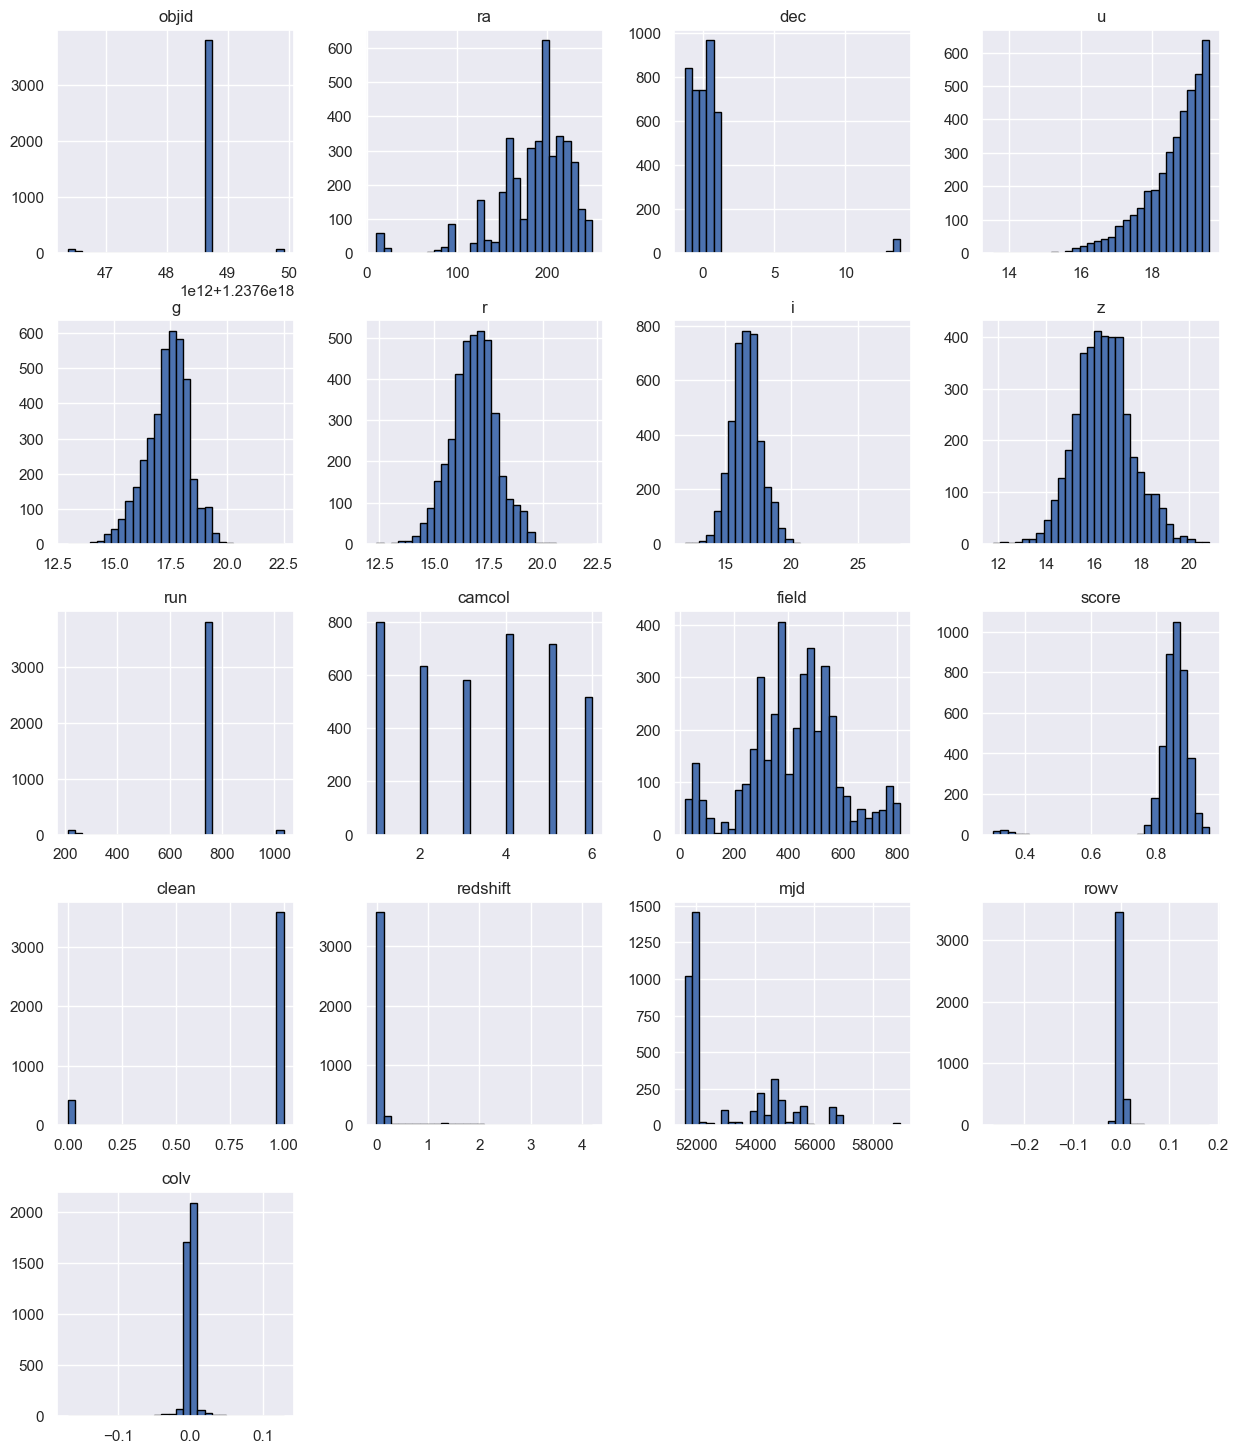

In [ ]:
data.hist(figsize=(15,18),bins=30,edgecolor="black")

In [295]:
#Entendimiento del tamaño del data Set a ser manejado
print('Dimensiones de los datos: ', data.shape, 'El primer valor corresponde a filas y el segundo a columnas')

Dimensiones de los datos:  (4000, 18) El primer valor corresponde a filas y el segundo a columnas


In [296]:
# Visualizacion de los primeros 10 datos
display(data.head(10))

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
0,1237648722306924571,185.574486,40.187398,19.11034,17.62099,17.03464,16.82993,16.71711,756,5,466,0.864145,1,STAR,8.780529e-05,54140,0.002418,0.001363
1,1237648720167436418,203.801841,-48.925211,18.90957,17.62940,17.01465,16.62059,16.35239,756,1,588,0.816541,1,GALAXY,8.619995e-02,51955,0.008650,0.007056
2,1237648720685105352,160.034264,-24.157376,19.26340,17.67693,16.82551,16.42307,16.13864,756,2,295,0.870381,1,GALAXY,1.330486e-01,51913,0.003938,-0.002028
3,1237648703510937836,200.807373,-39.077125,18.82022,17.77765,17.38575,17.11128,16.93540,752,2,382,0.867801,1,GALAXY,8.636355e-02,51959,0.001839,0.001160
4,1237648720161275992,189.792404,-57.380593,18.91391,19.05355,19.46278,19.75660,20.09613,756,1,494,0.833824,1,STAR,-4.090000e-08,54562,0.001929,-0.000465
5,1237648720132178408,123.386052,-59.902696,18.52214,17.45173,17.23112,17.16427,17.13214,756,1,50,0.851417,1,STAR,1.190440e-05,53816,-0.002165,-0.000364
6,1237648720165863598,200.243728,-51.333050,18.09523,16.82764,16.18942,15.83503,15.58671,756,1,564,0.815295,0,GALAXY,4.815651e-02,51984,-0.011610,0.002361
7,1237648704054624442,216.256661,-12.650848,19.20765,18.73173,18.84302,18.98353,19.15128,752,3,486,0.804086,1,STAR,-2.234210e-04,51613,-0.002153,-0.001026
8,1237648722308890870,190.050847,39.859061,17.82951,15.90091,15.02515,14.61881,14.30353,756,5,496,0.822898,1,GALAXY,4.634102e-02,51941,-0.000474,-0.001548
9,1237648720163963081,195.951990,-55.347995,17.76132,16.51327,15.89811,15.53069,15.31236,756,1,535,0.811336,1,GALAXY,8.944633e-02,51986,0.000894,0.001024


In [297]:
# Imprimimos los diferentes tipos de las columnas
data.dtypes

objid         int64
ra          float64
dec         float64
u           float64
g           float64
r           float64
i           float64
z           float64
run           int64
camcol        int64
field         int64
score       float64
clean         int64
class        object
redshift    float64
mjd           int64
rowv        float64
colv        float64
dtype: object

In [298]:
# Imprimir las columnas numericas
columnasNumericas= data.select_dtypes(include=['int','float']).columns
print(columnasNumericas)

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field',
       'score', 'clean', 'redshift', 'mjd', 'rowv', 'colv'],
      dtype='object')


In [299]:
data.describe( include='all')

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
count,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000,4000.000000,4000.000000,4000.000000,4000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GALAXY,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1857,NaN,NaN,NaN,NaN
mean,1.237649e+18,185.523295,14.264288,18.609049,17.363397,16.839856,16.597712,16.439392,743.829000,3.37625,419.602000,0.851765,0.895500,NaN,0.134015,52957.124750,0.000218,-0.000090
std,4.244222e+11,41.689446,114.653131,0.839431,0.950964,1.055343,1.141252,1.190502,98.865936,1.69909,167.162063,0.071311,0.305946,NaN,0.379742,1601.148131,0.008794,0.007457
min,1.237646e+18,10.469743,-71.778038,13.551780,12.974870,12.362850,12.010790,11.799530,211.000000,1.00000,19.000000,0.301912,0.000000,NaN,-0.003322,51608.000000,-0.264516,-0.168807
25%,1.237649e+18,162.474666,-36.200842,18.170375,16.796110,16.190785,15.870782,15.628205,752.000000,2.00000,311.000000,0.836866,1.000000,NaN,0.000106,51821.000000,-0.001212,-0.001609
50%,1.237649e+18,195.815451,3.055942,18.843745,17.472525,16.850835,16.571195,16.402665,756.000000,3.00000,434.000000,0.860675,1.000000,NaN,0.032038,51986.000000,0.000322,0.000125
75%,1.237649e+18,214.348425,33.999065,19.261563,17.997818,17.506640,17.258833,17.147037,756.000000,5.00000,527.000000,0.879834,1.000000,NaN,0.086479,54468.000000,0.001698,0.001672


### Analisis de la calidad de los datos

##### Completitud

In [300]:
data.isnull().sum()
data.isna().sum()

objid       0
ra          0
dec         0
u           0
g           0
r           0
i           0
z           0
run         0
camcol      0
field       0
score       0
clean       0
class       0
redshift    0
mjd         0
rowv        0
colv        0
dtype: int64

Al hacer un examen de completitud de los datos podemos ver que no hay datos nulos en ninguna columna del data frame

##### Unicidad

In [301]:
duplicados = data[data.duplicated()]

duplicados_todos = data[data.duplicated(keep=False)]

num_duplicados = data.duplicated().sum()

print(f"Total de filas duplicadas: {data.duplicated().sum()}")
print(duplicados_todos)


Total de filas duplicadas: 17
                    objid          ra        dec         u         g  \
88    1237648703513428079  206.374167 -44.786578  18.28101  17.18856   
109   1237648721231609897  182.015940  -6.680711  17.96686  16.91550   
114   1237646382079606869   94.679499  48.261439  18.47695  16.94897   
299   1237648721756225804  154.036159  23.945646  19.50457  18.08980   
629   1237648720687988788  166.623017 -31.319582  19.55528  17.73928   
642   1237648720715710772  229.932143 -34.821520  18.34448  17.39741   
718   1237648721789780467  230.664376  13.145898  19.48961  18.21590   
719   1237648721788993889  228.864817  18.183348  18.88618  17.66549   
856   1237648705679065271  247.896821  56.774917  16.74659  15.61752   
897   1237646382079672642   94.883887  56.762099  17.03847  15.47224   
1231  1237648720163832016  195.688105 -49.766069  19.20444  18.01077   
1523  1237648705679065271  247.896821  56.774917  16.74659  15.61752   
1533  1237648705134461016  230.219

Podemos ver que si hay filas duplicadas por tanto se eliminarn las 17 filas que se encuentran duplicadas

In [302]:
data = data.drop_duplicates()
print("Data duplicada eliminada, hacemos verificacion",{data.duplicated().sum()})

Data duplicada eliminada, hacemos verificacion {0}


##### Consistencia

In [303]:
data['ra'].value_counts()

ra
185.574486    1
189.234768    1
147.394044    1
161.558526    1
170.899310    1
             ..
187.643235    1
153.656882    1
153.327761    1
123.194360    1
190.920230    1
Name: count, Length: 3983, dtype: int64

##### Estandarizacion

### Revisando la Columna 'ra' la cual describe Ubicación del objeto en su componente de ascensión recta de coordenada celeste.

In [304]:
data['ra'].describe()

count    3983.000000
mean      185.492078
std        41.675011
min        10.469743
25%       162.463210
50%       195.804913
75%       214.315696
max       249.758313
Name: ra, dtype: float64

In [305]:
#Revisar si hay datos Nulos en la columna ra
data['ra'].isna().sum()

0

In [306]:
# Ya que Ra describe la ubicación del objeto en su componente de ascensión recta de coordenada celeste. Este valor debe de estar entre 0 y 360 grados.
df_out_rango = data[(data["ra"] < 0) | (data["ra"] > 360)]
print(df_out_rango)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


162.4632096 214.31569555 51.85248594999999
84.68448067500002 292.094424475


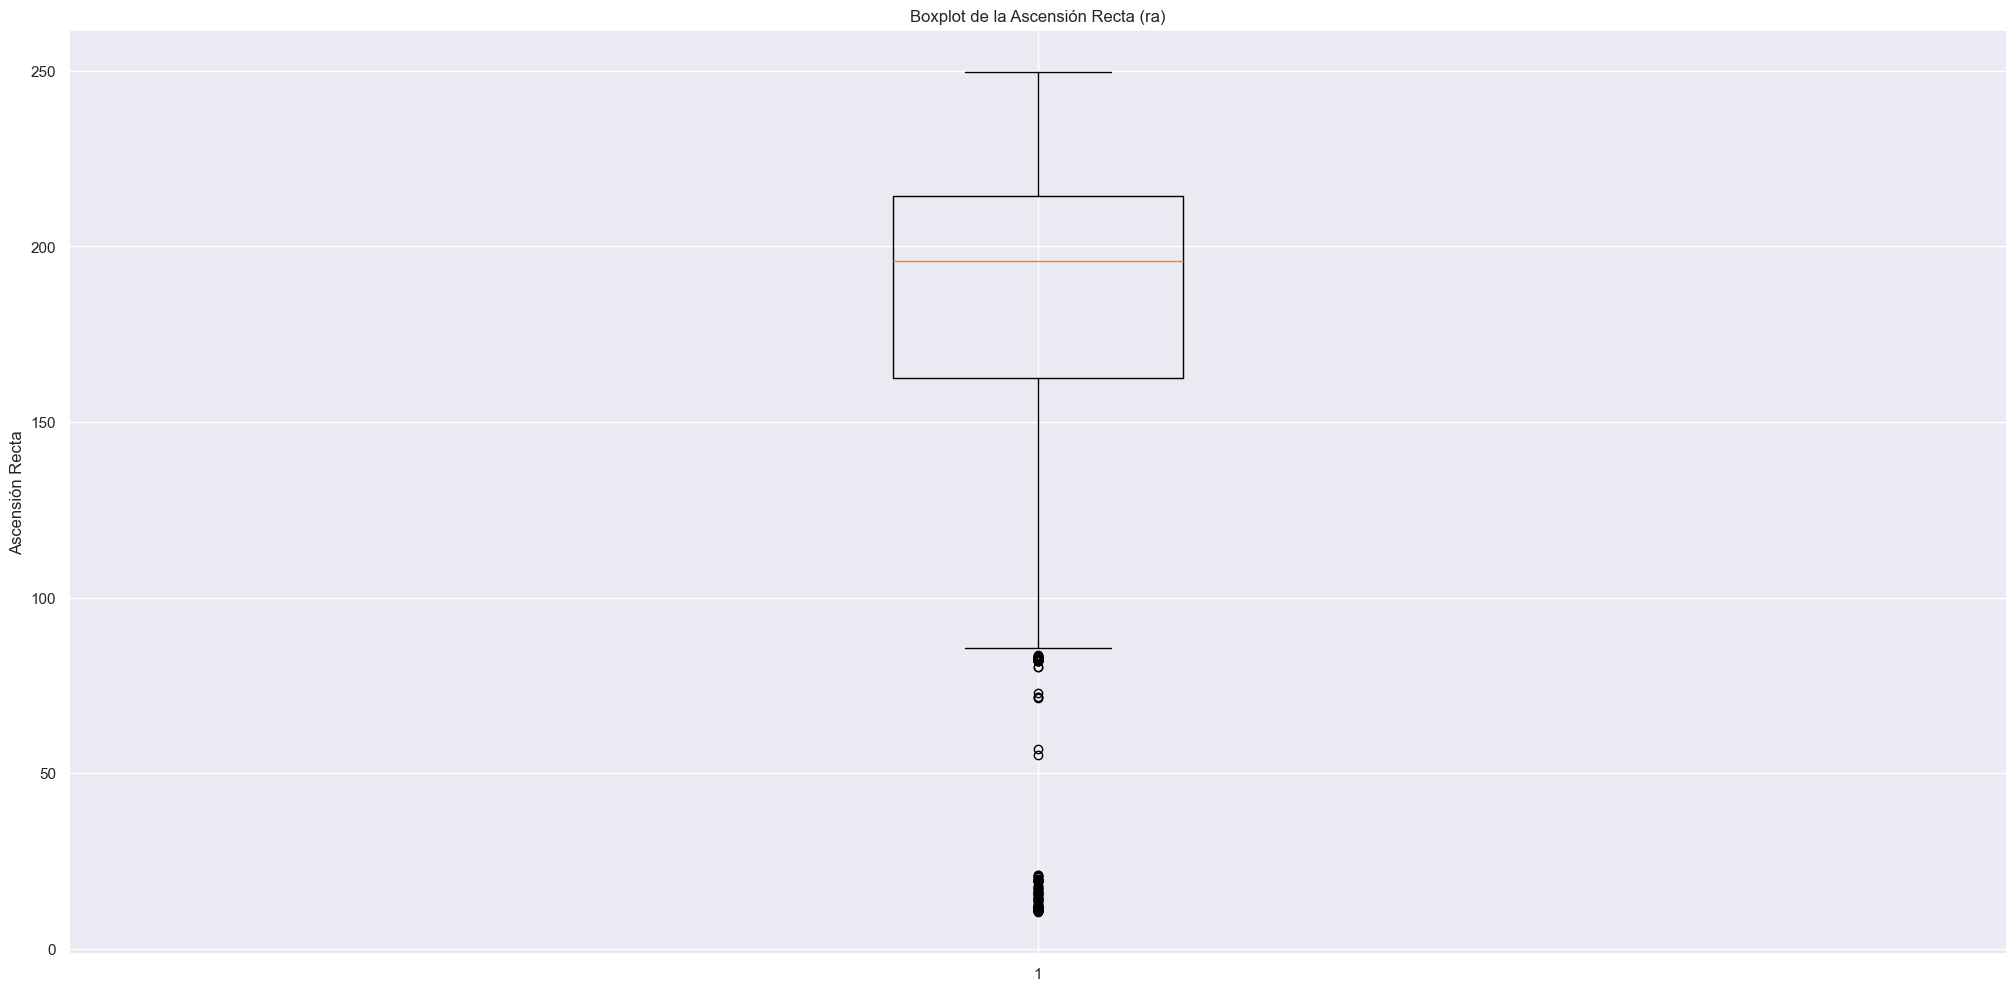

In [307]:
#Revisamos si se encuentra dentro del rango intercuartil, los valores que se encuentren por fuera de esto son outlayers [Q1−1.5×IQR,Q3+1.5×IQR]

Q1 = data['ra'].quantile(0.25)
Q3 = data['ra'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data[(data['ra'] < lower_bound) | (data['ra'] > upper_bound)]
# print(outliers['ra'])
outliers
plt.boxplot(data['ra'])
plt.title("Boxplot de la Ascensión Recta (ra)")
plt.ylabel("Ascensión Recta")
plt.show()

PENDIENTE PONER EN TIPO MARKDOWN
Distribución General:
La mediana (línea naranja) se encuentra cerca del centro del cajón, indicando que la distribución no está demasiado sesgada.
La mayoría de los datos se encuentran en el rango intercuartil (IQR), entre el primer y tercer cuartil.
Valores Atípicos (Outliers):
Se observan varios outliers en la parte inferior, lo que sugiere que hay valores significativamente bajos de ascensión recta en comparación con la mayoría de los datos.
Algunos de estos valores están bastante lejos del límite inferior del bigote, indicando que podrían ser errores de medición o registros especiales que deben analizarse más a fondo.
Límites de los Bigotes:
El límite inferior del bigote está alrededor de 90 pero hay valores por debajo de 50, que se consideran atípicos según el método del IQR.
El límite superior está alrededor de 250, sin outliers significativos en esta dirección, lo que sugiere que los valores altos no presentan anomalías.

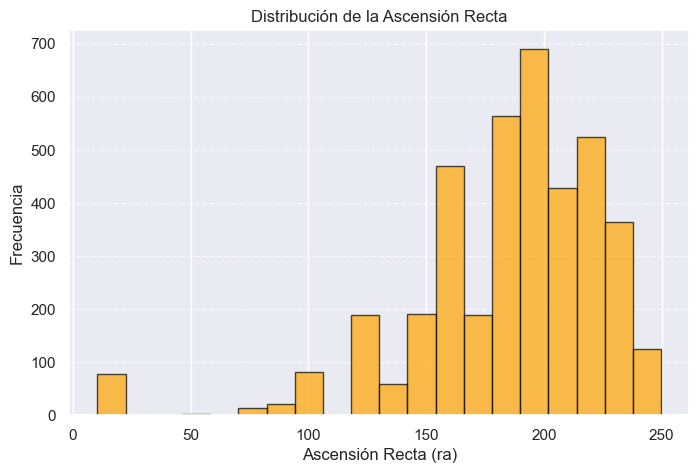

In [308]:
# Crear el histograma para visualizar la distribución de 'ra'
plt.figure(figsize=(8, 5))
plt.hist(data["ra"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (ra)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [309]:
# for col in data.select_dtypes(include=['object']):
#     print(f"Valores únicos en {col}:\n", data[col].unique())

## Columna dec
Describe: Ubicación del objeto en su componente de declinación de coordenada celeste.

In [310]:
data['dec'].describe()

count    3983.000000
mean       14.314905
std       114.863031
min       -71.778038
25%       -36.202090
50%         3.036634
75%        33.977314
max       793.776320
Name: dec, dtype: float64

In [311]:
#Ya que Dec describe la ubicación del objeto en su componente de declinación de coordenada celeste. Este valor debe de estar entre -90 y 90 grados.
out_rango = data[(data["dec"] < -90) | (data["dec"] > 90)]
print(out_rango)

                    objid         ra         dec         u         g  \
29    1237649918428708879  14.607180  782.547932  16.82643  15.43794   
67    1237649918427529256  11.841490  788.275356  18.99192  17.76341   
122   1237649918430675099  19.289872  762.471245  19.39130  17.31409   
140   1237649918427463866  11.755019  784.916269  19.58155  18.49723   
189   1237649918427332774  11.414186  785.036091  18.42381  16.56606   
...                   ...        ...         ...       ...       ...   
3654  1237649918427660313  12.091733  788.780188  17.67724  16.00506   
3739  1237649918428119075  13.239400  790.851466  18.17234  16.91165   
3759  1237649918431395974  20.967766  761.676817  18.24642  17.08067   
3883  1237649918427267203  11.165981  789.732934  19.52778  18.48113   
3996  1237649918427267086  11.165126  787.544236  17.46665  15.96142   

             r         i         z   run  camcol  field     score  clean  \
29    14.98633  14.71074  14.70645  1035       1     60  0.

-36.202089621657976 33.977314126969475 70.17940374862745
-141.47119524459913 139.24641974991064


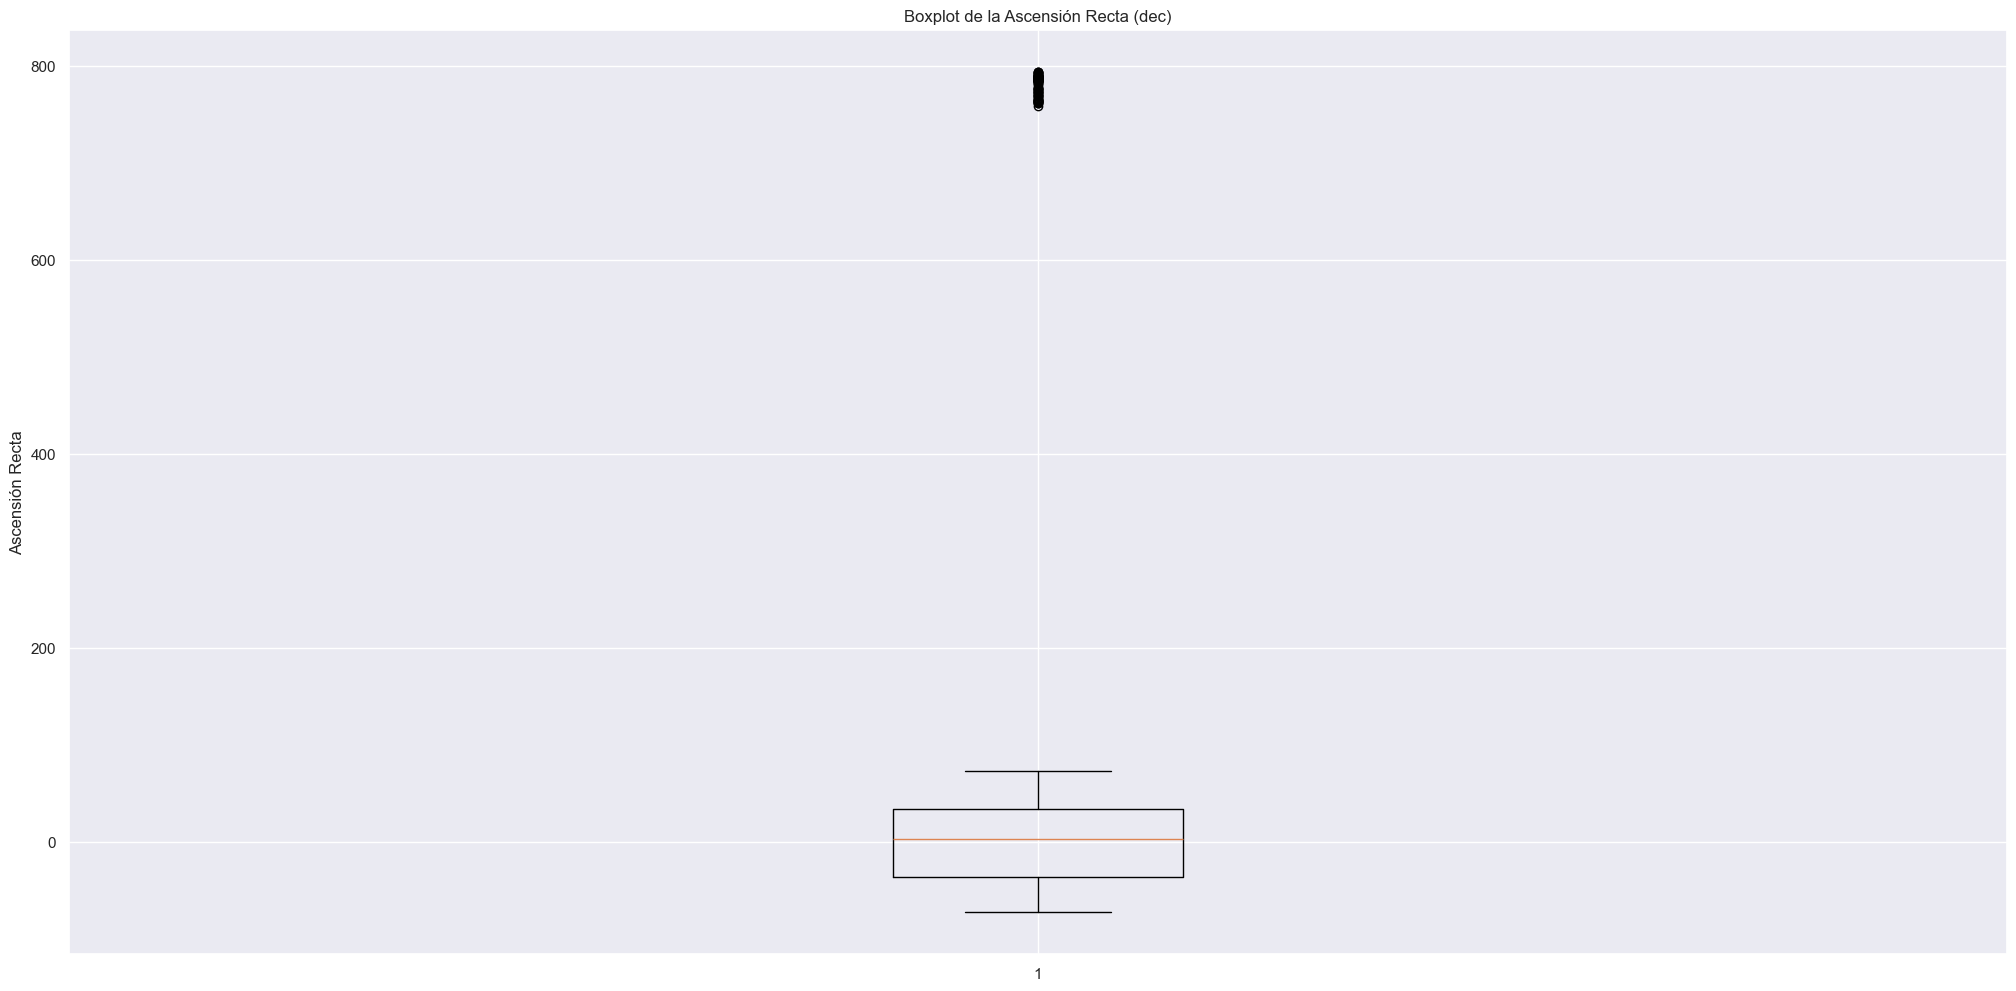

In [312]:
Q1 = data['dec'].quantile(0.25)
Q3 = data['dec'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data[(data['dec'] < lower_bound) | (data['dec'] > upper_bound)]
# print(outliers['dec'])
outliers
plt.boxplot(data['dec'])
plt.title("Boxplot de la Ascensión Recta (dec)")
plt.ylabel("Ascensión Recta")
plt.show()


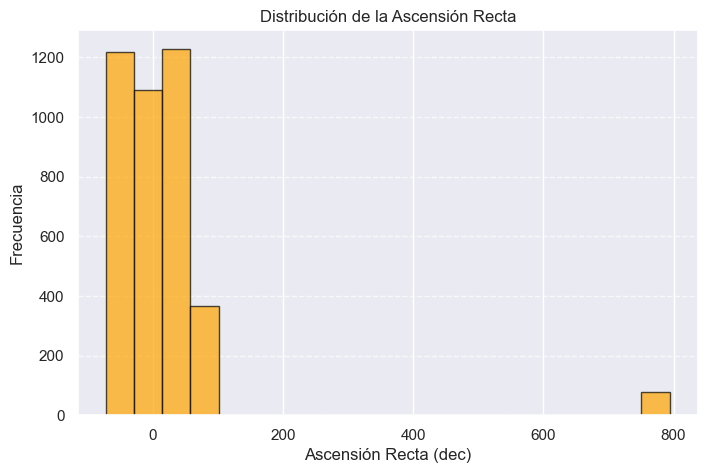

In [313]:
plt.figure(figsize=(8, 5))
plt.hist(data["dec"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (dec)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

### Vamos a revisar ese dato que se sale de la asension de la recta normal

In [314]:
# Valores a revisar ya que son valores lejos del centro
outliers2 = data[(data['dec'] > 10)]
outliers2

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
0,1237648722306924571,185.574486,40.187398,19.11034,17.62099,17.03464,16.82993,16.71711,756,5,466,0.864145,1,STAR,0.000088,54140,0.002418,0.001363
8,1237648722308890870,190.050847,39.859061,17.82951,15.90091,15.02515,14.61881,14.30353,756,5,496,0.822898,1,GALAXY,0.046341,51941,-0.000474,-0.001548
10,1237648722831409163,157.264686,67.018153,16.29776,15.26695,15.09390,15.05828,15.10017,756,6,277,0.849116,1,STAR,0.000012,51957,0.000143,-0.000088
11,1237648721754914875,151.011930,19.692397,19.00329,17.36013,16.67788,16.41988,16.27547,756,4,235,0.889983,0,STAR,-0.000081,54479,0.004332,0.003924
14,1237648705678213667,245.943070,50.864445,19.07316,17.33798,16.44005,15.89485,15.53507,752,6,684,0.851995,1,QSO,0.056787,52000,0.000309,-0.002255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,1237646382079803986,95.226126,54.846441,19.06613,17.34293,16.72245,16.43074,16.22178,211,6,362,0.816245,1,STAR,0.000072,52931,0.000449,-0.000302
3991,1237648722832982102,160.966485,60.830648,19.26472,17.15761,16.11110,15.66093,15.30986,756,6,301,0.852492,1,GALAXY,0.115905,51910,0.002422,0.001939
3992,1237646381542867245,95.002628,25.161738,18.96944,17.39834,17.09692,16.97927,16.86172,211,5,361,0.837128,1,S,0.000249,52931,-0.000172,0.000898
3993,1237648721753080096,146.887742,12.459195,19.52121,17.74410,16.88671,16.40612,16.02948,756,4,207,0.850950,1,GALAXY,0.062968,51630,0.001537,-0.006798


## Columna U
Magnitud del objeto capturada en el filtro ultravioleta. Valor mayor a 0.

In [315]:
data['u'].describe()

count    3983.000000
mean       18.609083
std         0.839262
min        13.551780
25%        18.170070
50%        18.843730
75%        19.261455
max        19.599750
Name: u, dtype: float64

In [316]:
# Revisamos si es que existen valores por debajo del 0 
outliers = data[(data['u'] <= 0)]
outliers

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv


In [317]:
# Revisamos si es que existen valores por encima de 30, pq Normalmente, las magnitudes de objetos astronómicos en el filtro ultravioleta están en un rango entre -5 y 25.
outliers = data[(data['u'] > 30)]
outliers

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv


18.170070000000003 19.261454999999998 1.0913849999999954
16.53299250000001 20.89853249999999


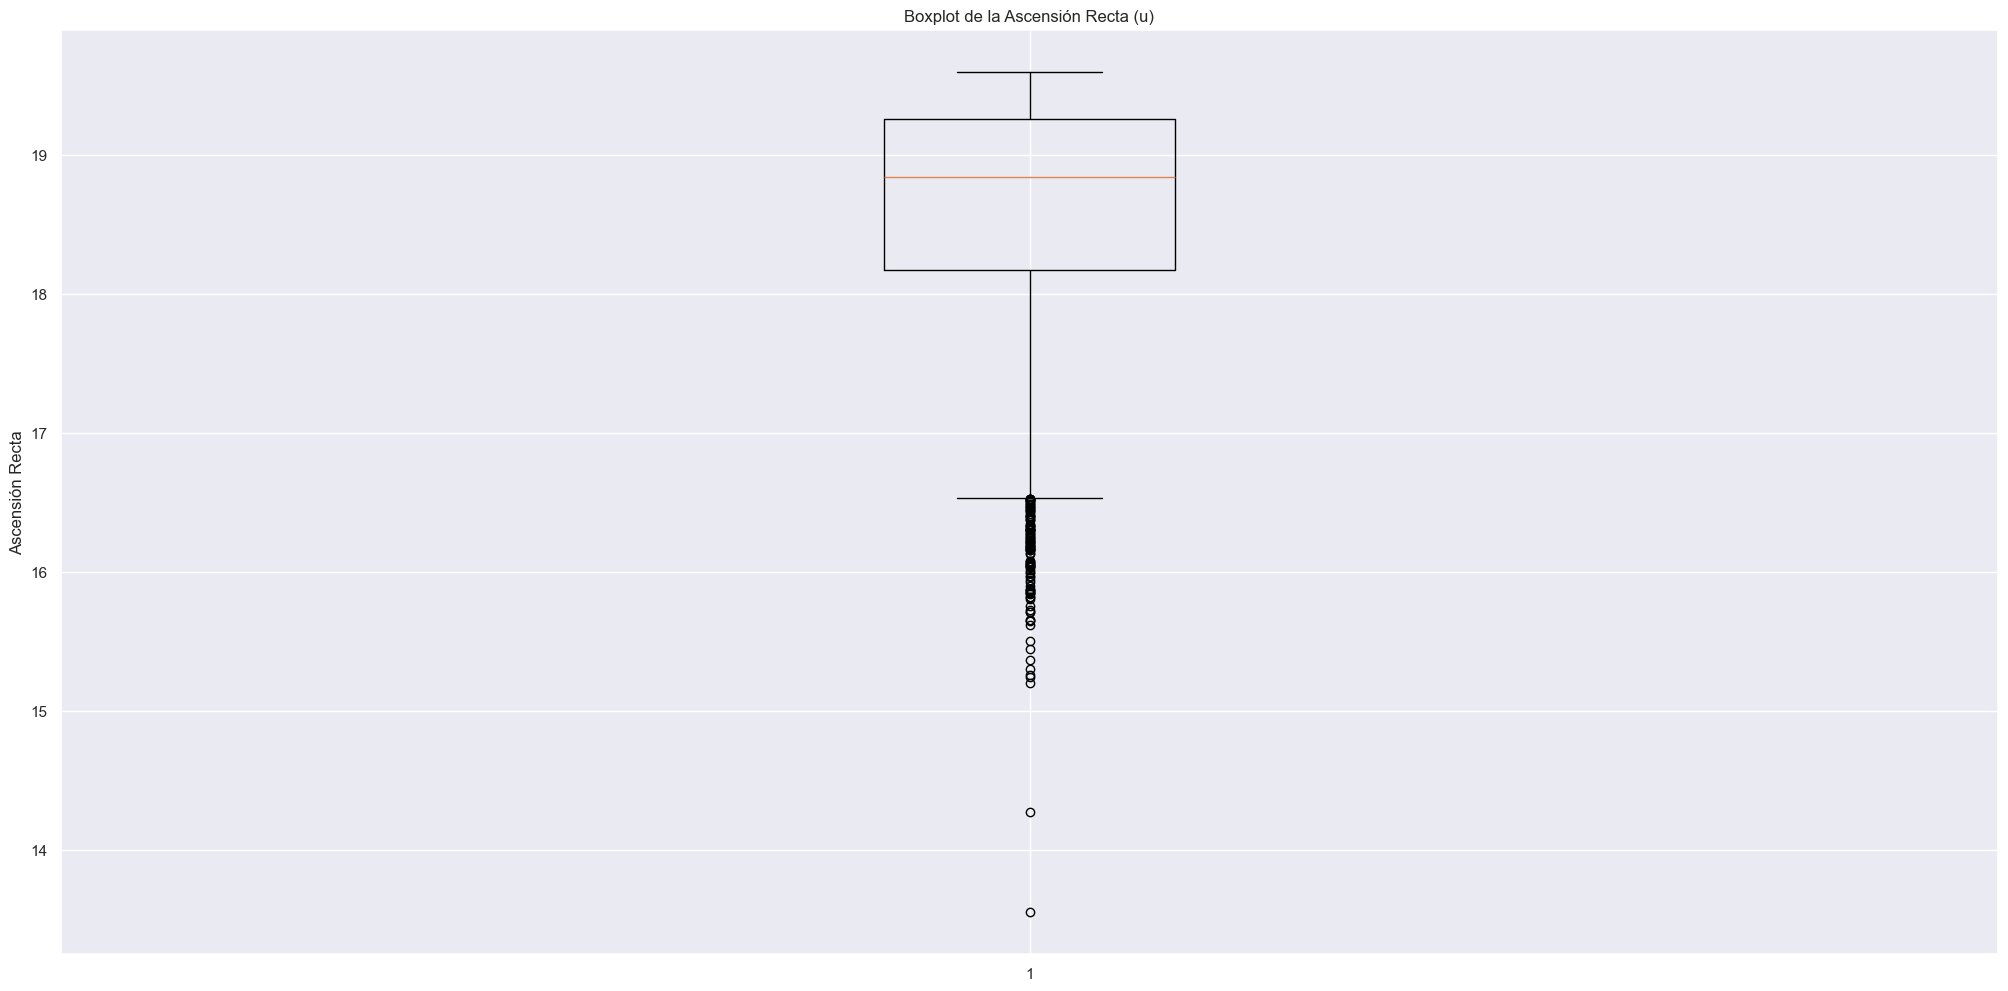

In [318]:
Q1 = data['u'].quantile(0.25)
Q3 = data['u'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data[(data['u'] < lower_bound) | (data['u'] > upper_bound)]
# print(outliers['dec'])
outliers
plt.boxplot(data['u'])
plt.title("Boxplot de la Ascensión Recta (u)")
plt.ylabel("Ascensión Recta")
plt.show()


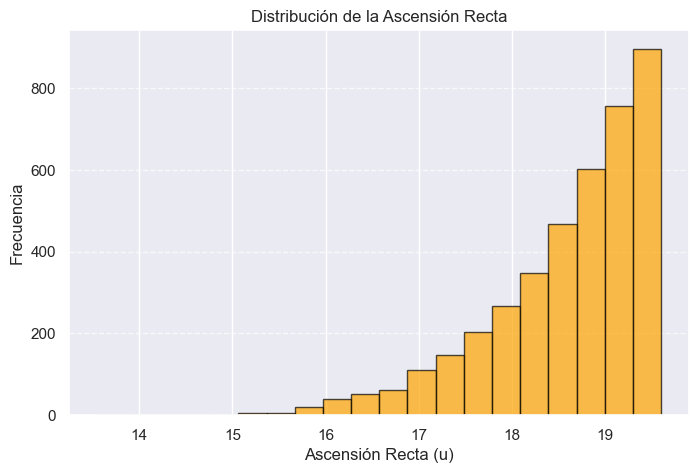

In [319]:
plt.figure(figsize=(8, 5))
plt.hist(data["u"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (u)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Columna g
Describe: Ubicación del objeto en su componente de declinación de coordenada celeste.

In [320]:
data['g'].describe()

count    3983.000000
mean       17.363316
std         0.950536
min        12.974870
25%        16.793890
50%        17.472600
75%        17.995970
max        22.497450
Name: g, dtype: float64

In [321]:
#Ya que g describe la magnitud del objeto en el filtro verde este va entre 12-25
out_rango = data[(data["g"] > 25) | (data["g"] < 12)]
print(out_rango)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


In [322]:
menor0 = data[(data["g"] <= 0)]
print(menor0)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


16.79389 17.99597 1.2020799999999987
14.990770000000003 19.79909


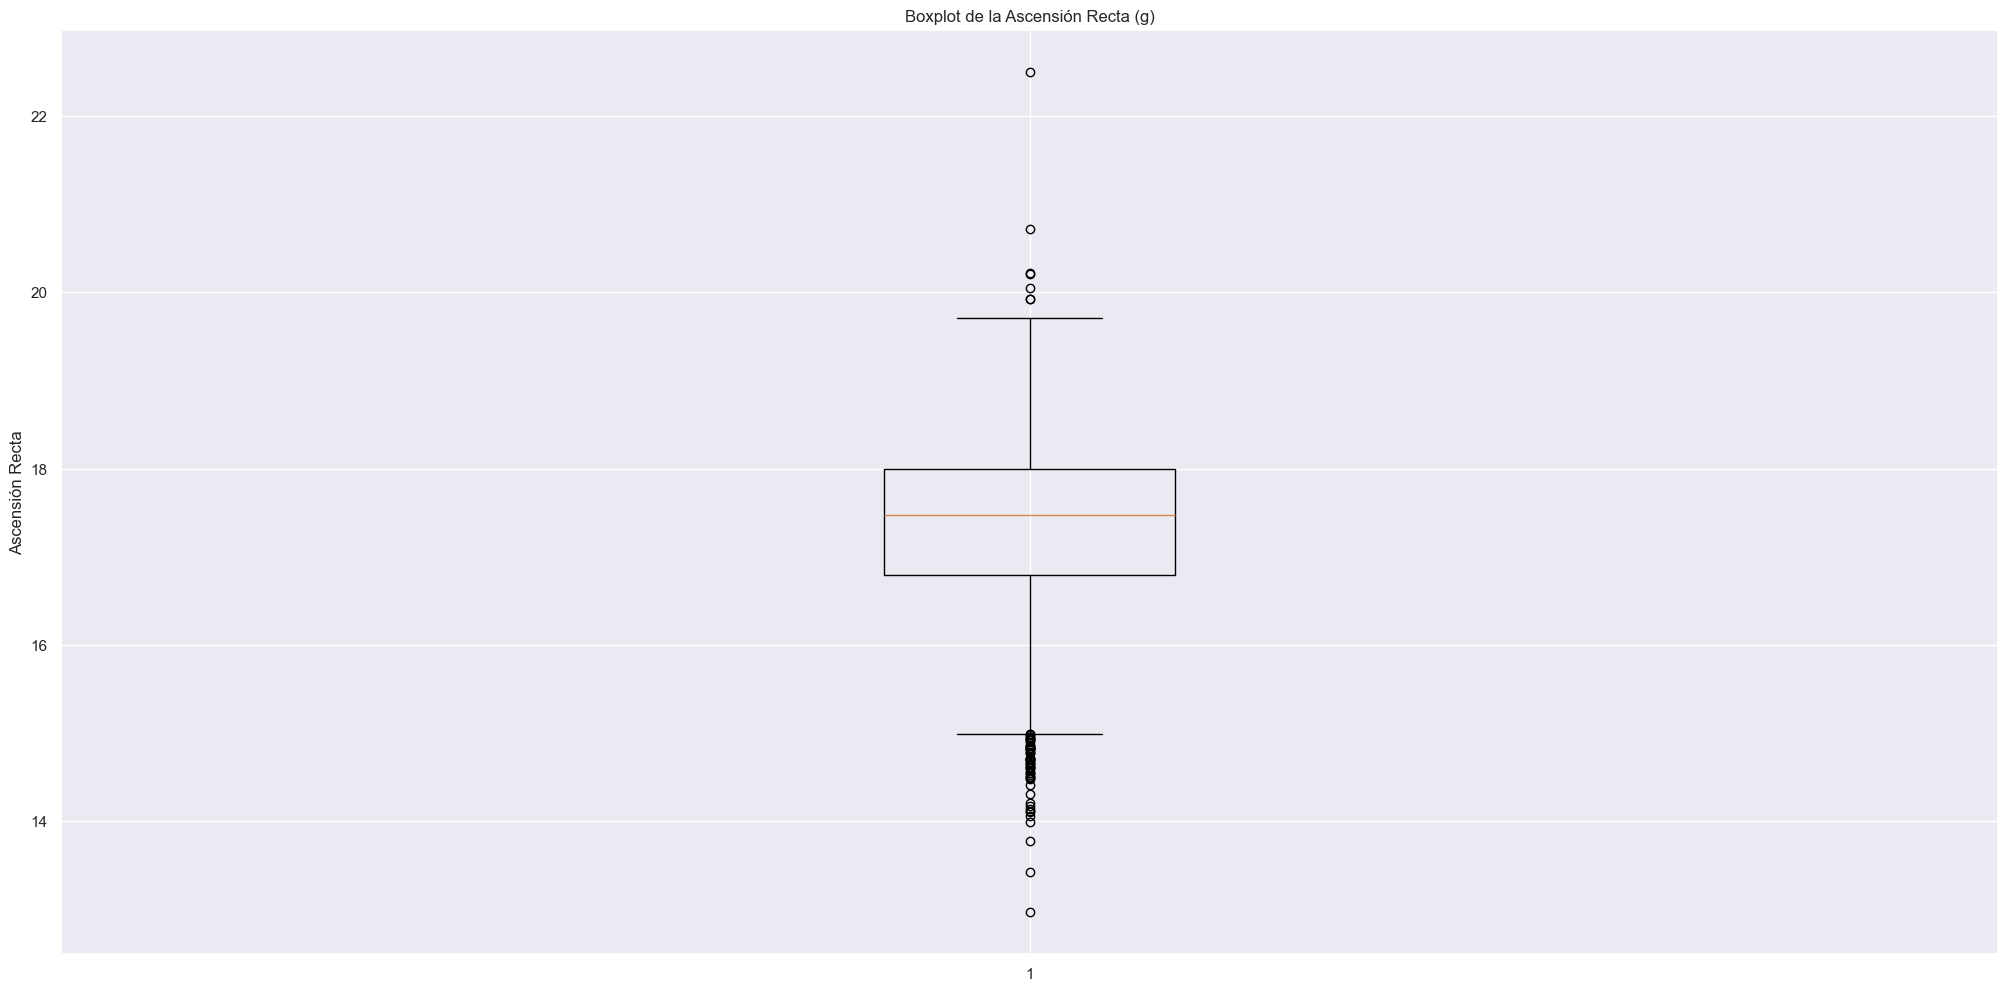

In [323]:
Q1 = data['g'].quantile(0.25)
Q3 = data['g'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data[(data['g'] < lower_bound) | (data['g'] > upper_bound)]
# print(outliers['g'])
outliers
plt.boxplot(data['g'])
plt.title("Boxplot de la Ascensión Recta (g)")
plt.ylabel("Ascensión Recta")
plt.show()

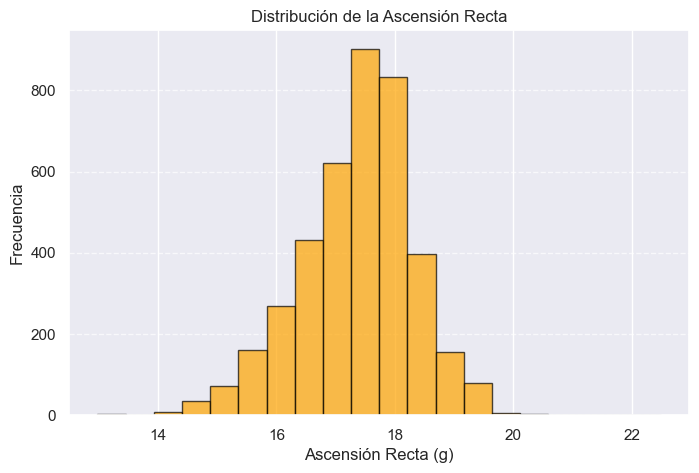

In [324]:
plt.figure(figsize=(8, 5))
plt.hist(data["g"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (g)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Columna r
Describe: Magnitud del objeto capturada en el filtro rojo. Valor mayor a 0.

In [325]:
data['r'].describe()

count    3983.000000
mean       16.839563
std         1.055080
min        12.362850
25%        16.190330
50%        16.850600
75%        17.508155
max        22.265960
Name: r, dtype: float64

In [326]:
menor0 = data[(data["r"] <= 0)]
print(menor0)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


## Columna RedShift


In [327]:
data["redshift"].describe()

count    3983.000000
mean        0.134292
std         0.380487
min        -0.003322
25%         0.000106
50%         0.031775
75%         0.086468
max         4.192597
Name: redshift, dtype: float64

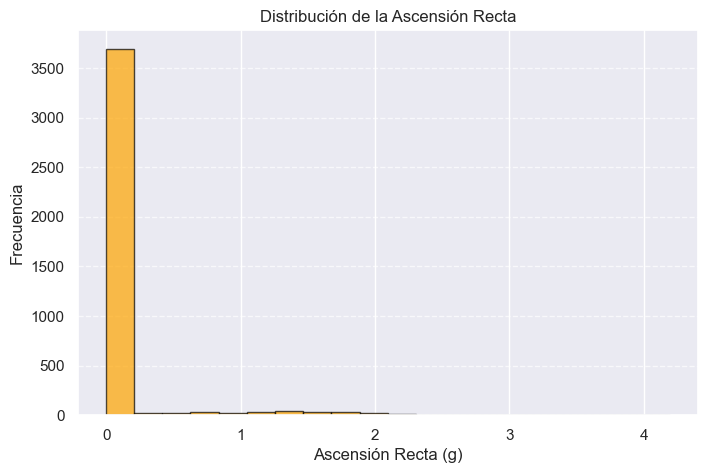

In [328]:
plt.figure(figsize=(8, 5))
plt.hist(data["redshift"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (g)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [329]:
data["redshift"].min()

-0.003321956

In [330]:
negativos = data[data["redshift"] < 0]  # Filtra los valores negativos
cantidad_negativos = negativos.shape[0]  # Cuenta cuántos son
print(f"Número de valores negativos en redshift: {cantidad_negativos}")

Número de valores negativos en redshift: 646


In [331]:
print(data.shape)
data = data[~((data["score"] < 0.4) & (data["clean"] == 0) & (data["redshift"]<=0))]
print(data.shape)

(3983, 18)
(3981, 18)


In [332]:
negativos = data[data["redshift"] < 0]  # Filtra los valores negativos
cantidad_negativos = negativos.shape[0]  # Cuenta cuántos son
print(f"Número de valores negativos en redshift: {cantidad_negativos}")

Número de valores negativos en redshift: 644


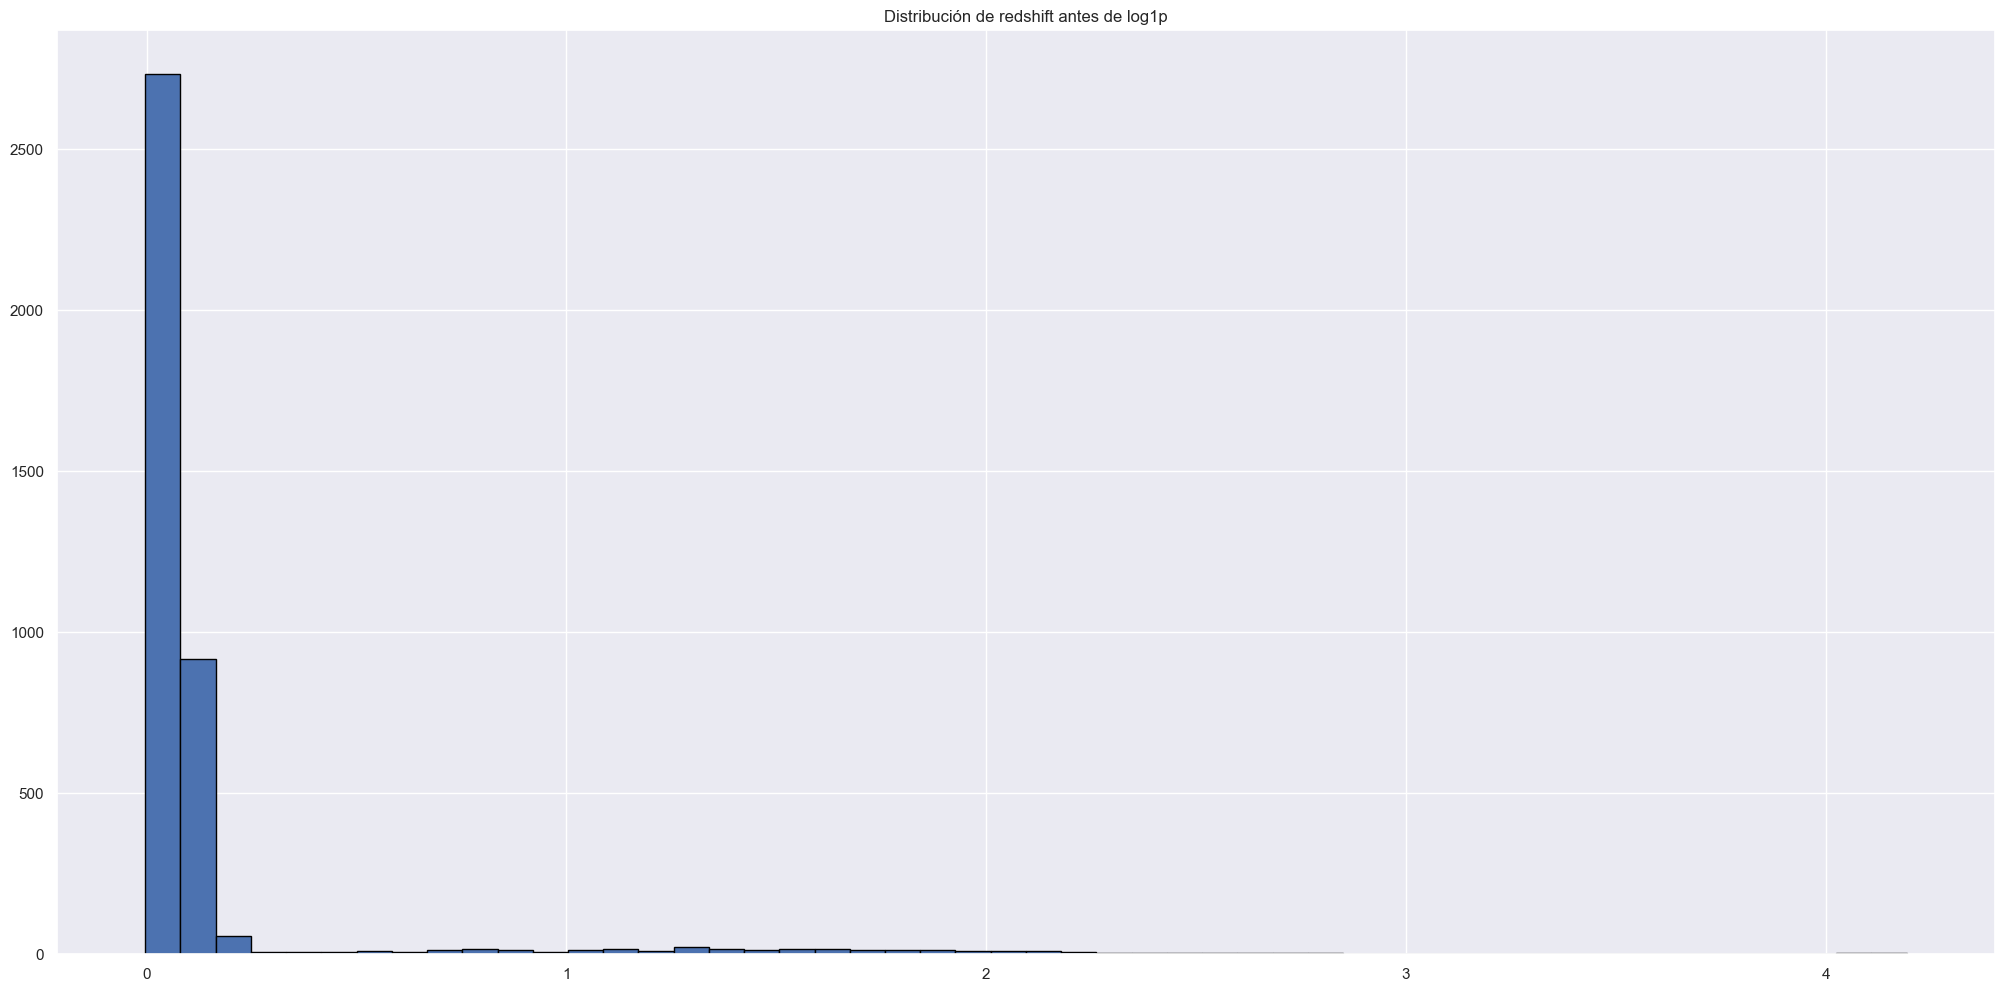

In [333]:
import matplotlib.pyplot as plt

plt.hist(data["redshift"], bins=50, edgecolor="black")
plt.title("Distribución de redshift antes de log1p")
plt.show()

In [334]:
# data_filtered = data[(data["redshift"] >= 0) & (data["redshift"] <= 7)]

# # Mostrar cuántos valores fueron eliminados
# print("Valores eliminados:", len(data) - len(data_filtered))
# data["redshift"] = log1p(data["redshift"])


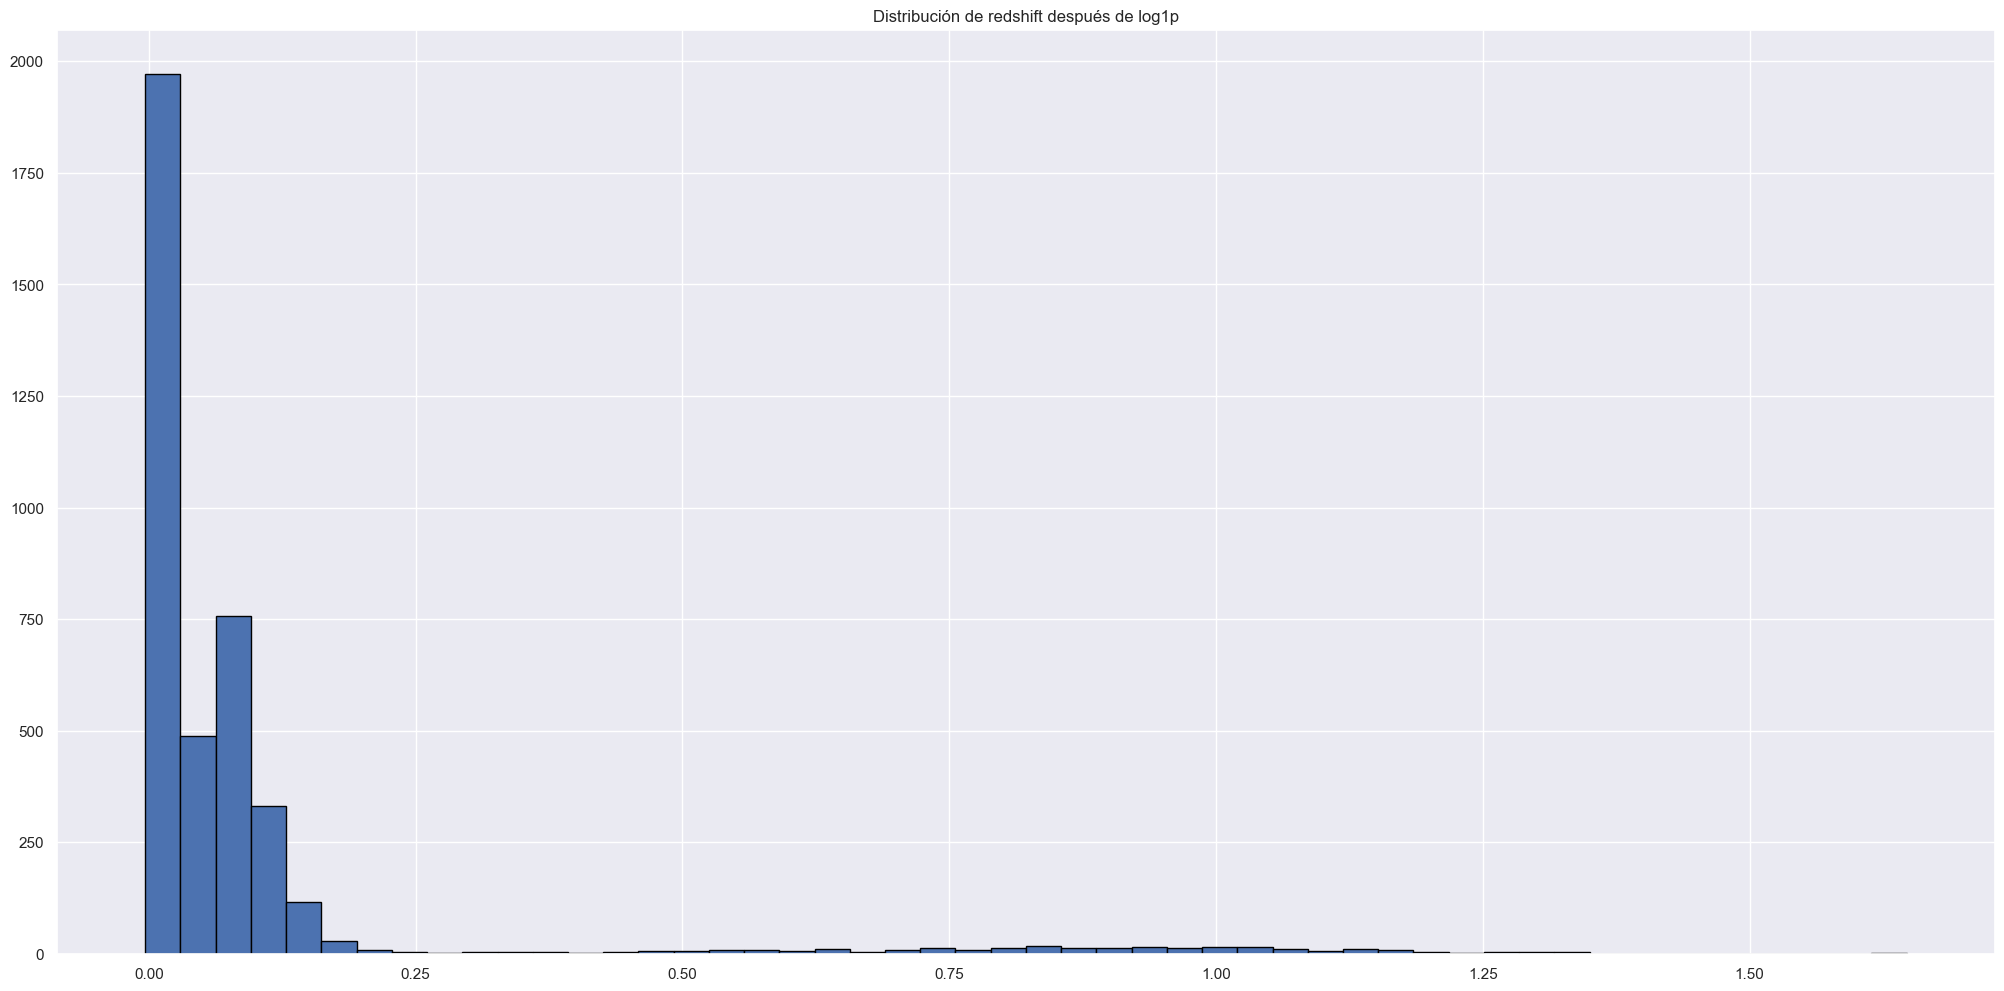

In [335]:
import numpy as np

data["redshift_log"] = np.log1p(data["redshift"])

plt.hist(data["redshift_log"], bins=50, edgecolor="black")
plt.title("Distribución de redshift después de log1p")
plt.show()


📌 1️⃣ Para manejar valores pequeños y cercanos a 0

redshift tiene muchos valores cerca de 0, y una transformación logarítmica puede expandir esos valores pequeños para mejorar la distribución de los datos.
📌 2️⃣ Para reducir el impacto de valores grandes (outliers)

Si redshift tiene algunos valores muy altos (z > 3), la regresión puede verse afectada.
log1p comprime valores grandes, haciendo que el modelo sea más estable.

In [336]:
data["redshift"].describe()

count    3981.000000
mean        0.134359
std         0.380570
min        -0.003322
25%         0.000108
50%         0.031830
75%         0.086470
max         4.192597
Name: redshift, dtype: float64

## Columna z
Describe: Magnitud del objeto capturada en el filtro casi-infrarrojo. Valor mayor a 0.

In [337]:
data['z'].describe()

count    3981.000000
mean       16.438960
std         1.190723
min        11.799530
25%        15.627590
50%        16.401350
75%        17.147810
max        20.847690
Name: z, dtype: float64

## Columna i
Describe: Magnitud del objeto capturada en el filtro infrarrojo. Valor mayor a 0.

In [338]:
data['i'].describe()

count    3981.000000
mean       16.597279
std         1.141377
min        12.010790
25%        15.870730
50%        16.568220
75%        17.259840
max        28.179630
Name: i, dtype: float64

## Columna score

#### 1. Visualizar como se distribuyen los datos entre 0 y 1 por cuartiles

In [339]:
data['score'].describe()

count    3981.000000
mean        0.852013
std         0.070519
min         0.301912
25%         0.836868
50%         0.860675
75%         0.879834
max         0.961145
Name: score, dtype: float64

#### 2. Visualización Gráfica

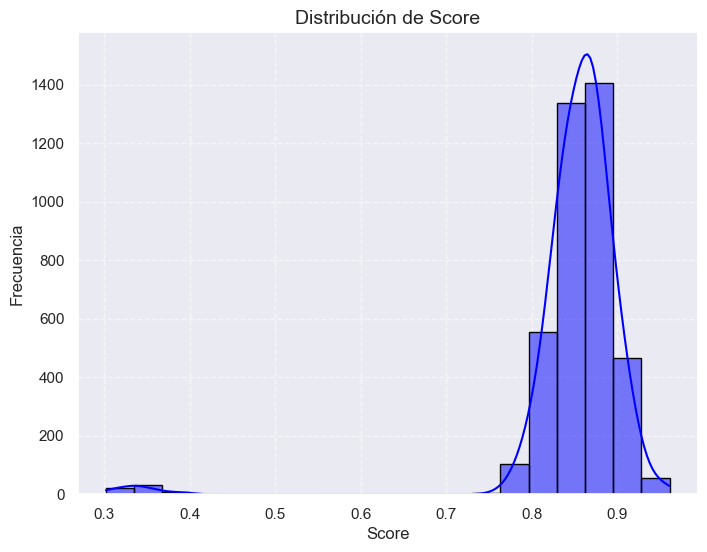

Esto nos dá a entender que la mayoría de las observaciones presentan una alta calidad, además no se presentaron datos fuera del rango 0 - 1


In [340]:
# Crear el histograma
plt.figure(figsize=(8, 6))
sb.histplot(data['score'], bins=20, kde=True, color='blue', edgecolor='black')
plt.title("Distribución de Score", fontsize=14)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
print("Esto nos dá a entender que la mayoría de las observaciones presentan una alta calidad, además no se presentaron datos fuera del rango 0 - 1")

#### 3. Eliminar datos que tienen una score y un clean 0

Decidimos eliminar ciertos datos con una score y clean bajo ya que no aportan mucho a nuestro analisis

In [341]:
print(data.shape)
data = data[~((data["score"] < 0.4) & (data["clean"] == 0))]
print(data.shape)

(3981, 19)
(3974, 19)


## Columna clean

#### 1. Describir por cuartiles los datos de clean

In [342]:
data['clean'].describe()

count    3974.000000
mean        0.897333
std         0.303562
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: clean, dtype: float64

#### 2. Análisis grafico para detectar anomalías

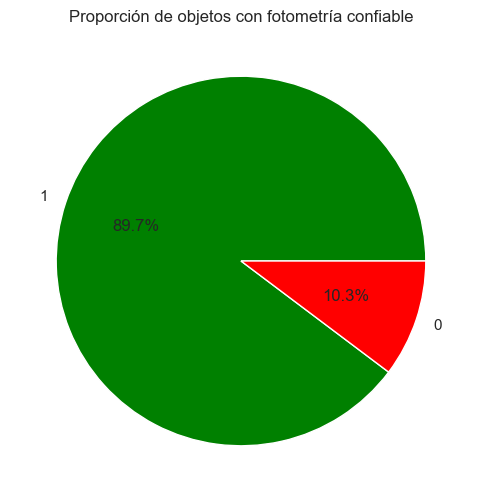

Se observa que todos los datos son binarios , es decir 0 o 1, no se detectaron anomalías


In [343]:
plt.figure(figsize=(6,6))
data['clean'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'])

plt.title("Proporción de objetos con fotometría confiable")
plt.ylabel("")
plt.show()
print("Se observa que todos los datos son binarios , es decir 0 o 1, no se detectaron anomalías")

## Columna camcol
Describe: Columna de la cámara en la que se registró el objeto.

camcol
1    797
4    749
5    714
2    629
3    580
6    505
Name: count, dtype: int64
Valores únicos: [5 1 2 3 6 4]


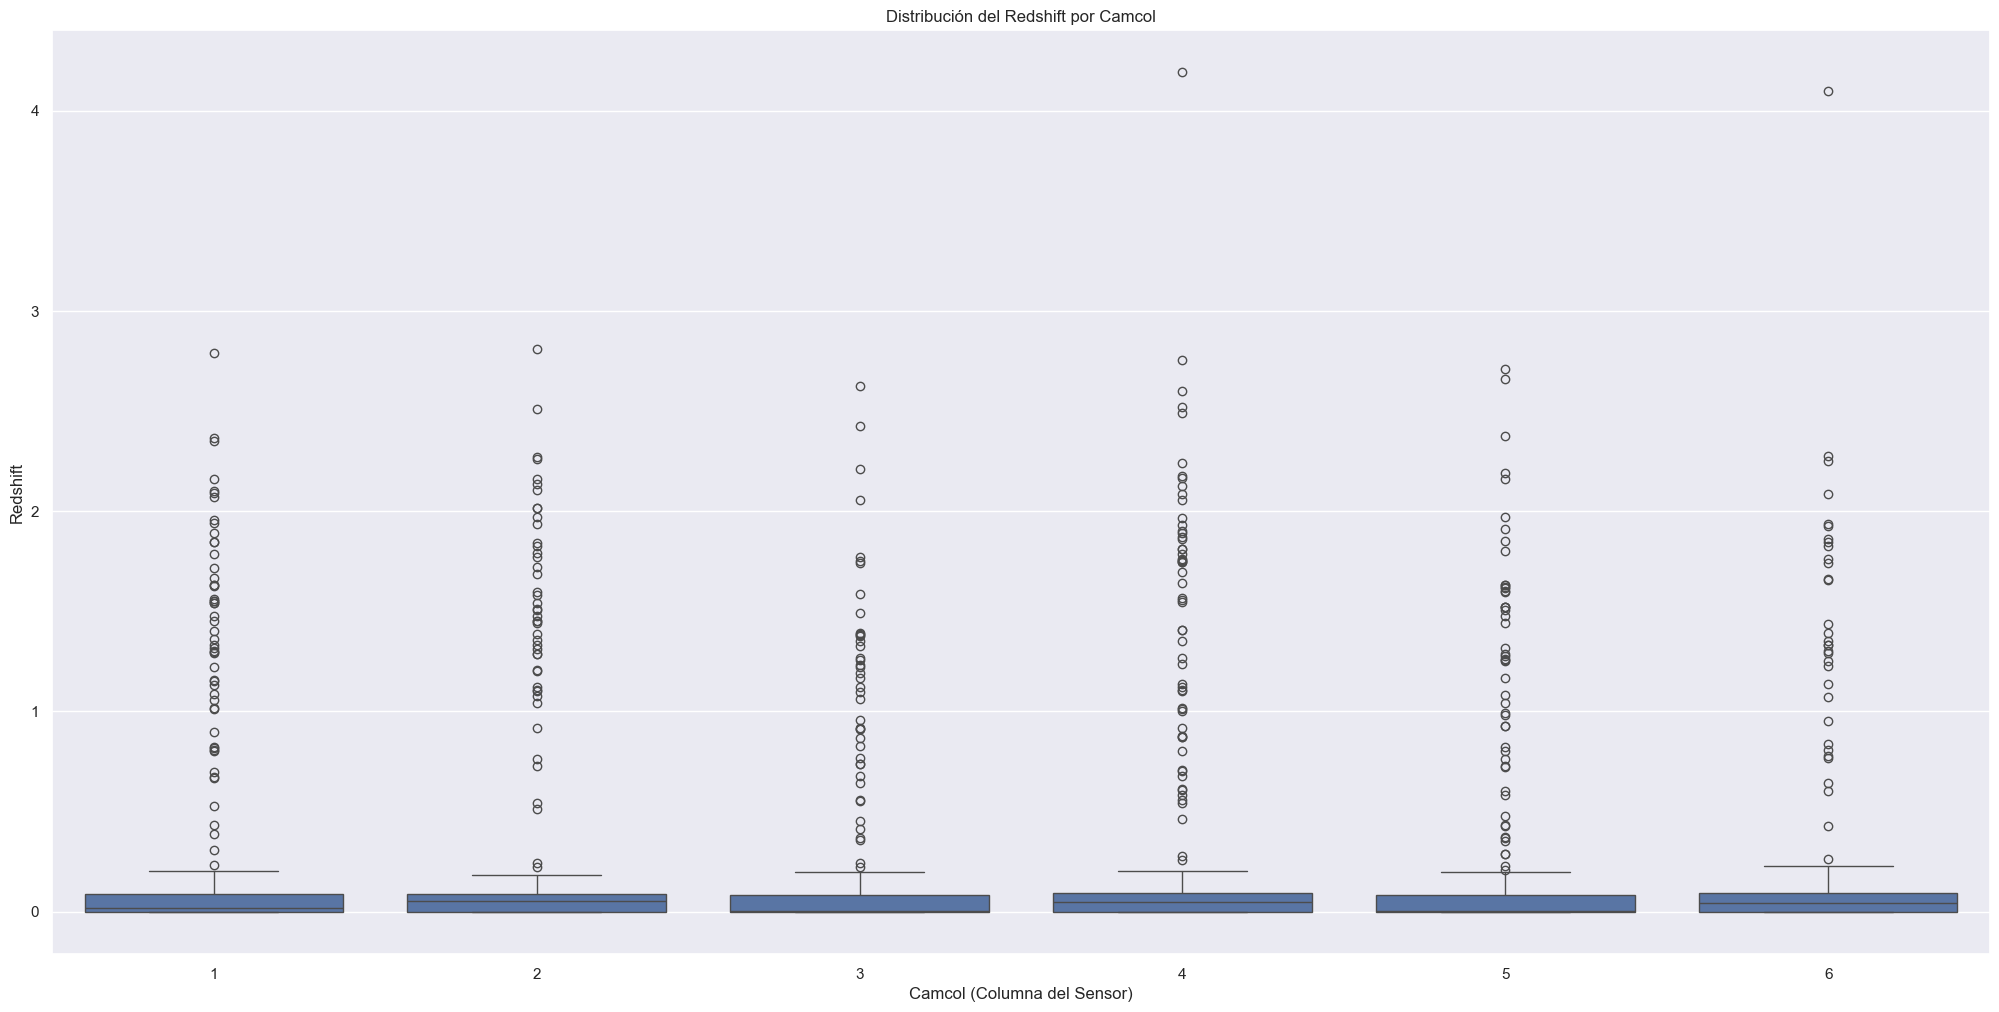

Correlación entre camcol y redshift: -0.0029476507126094515


In [344]:
print(data['camcol'].value_counts())
print("Valores únicos:", data['camcol'].unique())

#Podemos ver que es una columna numerica pero deberia de ser categorica solo toma valores 
# específicos como {1, 2, 3, 4, 5, 6}, es más una categoría que un número
sb.boxplot(x=data["camcol"], y=data["redshift"])
plt.xlabel("Camcol (Columna del Sensor)")
plt.ylabel("Redshift")
plt.title("Distribución del Redshift por Camcol")
plt.show()
correlation = data["camcol"].corr(data["redshift"])
print("Correlación entre camcol y redshift:", correlation)

In [345]:
data['camcol'] = data['camcol'].astype('category')
print("Tipo de dato:", data['camcol'].dtype)

Tipo de dato: category


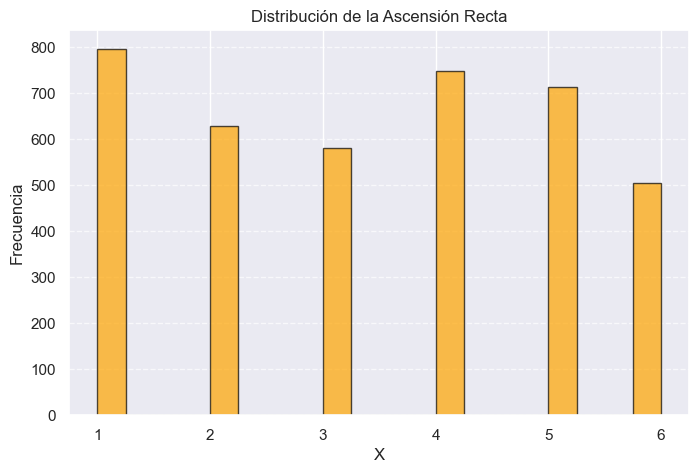

In [346]:
plt.figure(figsize=(8, 5))
plt.hist(data["camcol"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("X")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


Analizando la correlación decidimos que no es una variable que influye directamente al redshift entonces la omitimos

## Columna field
Describe: Sección de la columna de la cámara en la que se registró el objeto.


In [347]:
for col in data.columns:
    unique_values = data[col].nunique()
    print(f"{col}: {unique_values} valores únicos")

objid: 3974 valores únicos
ra: 3974 valores únicos
dec: 3974 valores únicos
u: 3943 valores únicos
g: 3944 valores únicos
r: 3954 valores únicos
i: 3950 valores únicos
z: 3959 valores únicos
run: 7 valores únicos
camcol: 6 valores únicos
field: 663 valores únicos
score: 1559 valores únicos
clean: 2 valores únicos
class: 6 valores únicos
redshift: 3923 valores únicos
mjd: 183 valores únicos
rowv: 3970 valores únicos
colv: 3969 valores únicos
redshift_log: 3923 valores únicos


In [348]:
print(data["field"].isna().sum())  # Cuenta los valores NaN en la columna


0


## Columna class

#### 1. Revisión de como se distribuyen las clases

In [349]:
data['class'].describe()
print("Valores únicos en 'class':", data['class'].unique())
print("\nValores nulos en 'class':", data['class'].isnull().sum())

# Ver distribución de las clases
print("\nDistribución de clases:")
print(data['class'].value_counts())

Valores únicos en 'class': ['STAR' 'GALAXY' 'QSO' 'S' 'QUASAR' 'G']

Valores nulos en 'class': 0

Distribución de clases:
class
GALAXY    1840
STAR      1624
QSO        291
S          174
G           44
QUASAR       1
Name: count, dtype: int64


#### 2. Hacer estandarización de las columnas

En este caso por intuición vamos a tomar los datos de clasificación G y convertirlos GALAXY

In [350]:
# Reemplazar 'G' por 'GALAXY'
data['class'] = data['class'].replace('G', 'GALAXY')

Por otro lado para los datos que tienen la clasificación S los modificaremos para que sean STAR

In [351]:
# Reemplazar 'S' por 'STAR'
data['class'] = data['class'].replace('S', 'STAR')

Tambien para hacer el uso de solo una etiqueta cambiamos Quasar por QSO

In [352]:
# Reemplazar 'QUASAR' por 'QSO'
data['class'] = data['class'].replace('QUASAR', 'QSO')

Luego volvemos a revisar si ya se hicieron los cambios correctamente

In [353]:
data['class'].describe()
print("Valores únicos en 'class':", data['class'].unique())
print("\nValores nulos en 'class':", data['class'].isnull().sum())

# Ver distribución de las clases
print("\nDistribución de clases:")
print(data['class'].value_counts())

Valores únicos en 'class': ['STAR' 'GALAXY' 'QSO']

Valores nulos en 'class': 0

Distribución de clases:
class
GALAXY    1884
STAR      1798
QSO        292
Name: count, dtype: int64


#### 3. Transformación para facilitar el modelo de regresión

Primero se hace una selección de las variables relevantes 

In [354]:
features=["ra","dec","u","g","r","z","i","class","redshift","mjd"]
data=data[features]
data.head()

,ra,dec,u,g,r,z,i,class,redshift,mjd
0,185.574486,40.187398,19.11034,17.62099,17.03464,16.71711,16.82993,STAR,8.780529e-05,54140
1,203.801841,-48.925211,18.90957,17.62940,17.01465,16.35239,16.62059,GALAXY,8.619995e-02,51955
2,160.034264,-24.157376,19.26340,17.67693,16.82551,16.13864,16.42307,GALAXY,1.330486e-01,51913
3,200.807373,-39.077125,18.82022,17.77765,17.38575,16.93540,17.11128,GALAXY,8.636355e-02,51959
4,189.792404,-57.380593,18.91391,19.05355,19.46278,20.09613,19.75660,STAR,-4.090000e-08,54562


In [355]:
dumies=pd.get_dummies(data["class"], dtype=int)
data=pd.concat([data, dumies], axis=1)
data.head()

,ra,dec,u,g,r,z,i,class,redshift,mjd,GALAXY,QSO,STAR
0,185.574486,40.187398,19.11034,17.62099,17.03464,16.71711,16.82993,STAR,8.780529e-05,54140,0,0,1
1,203.801841,-48.925211,18.90957,17.62940,17.01465,16.35239,16.62059,GALAXY,8.619995e-02,51955,1,0,0
2,160.034264,-24.157376,19.26340,17.67693,16.82551,16.13864,16.42307,GALAXY,1.330486e-01,51913,1,0,0
3,200.807373,-39.077125,18.82022,17.77765,17.38575,16.93540,17.11128,GALAXY,8.636355e-02,51959,1,0,0
4,189.792404,-57.380593,18.91391,19.05355,19.46278,20.09613,19.75660,STAR,-4.090000e-08,54562,0,0,1


#### 4. Análisis Gráfico de la columna

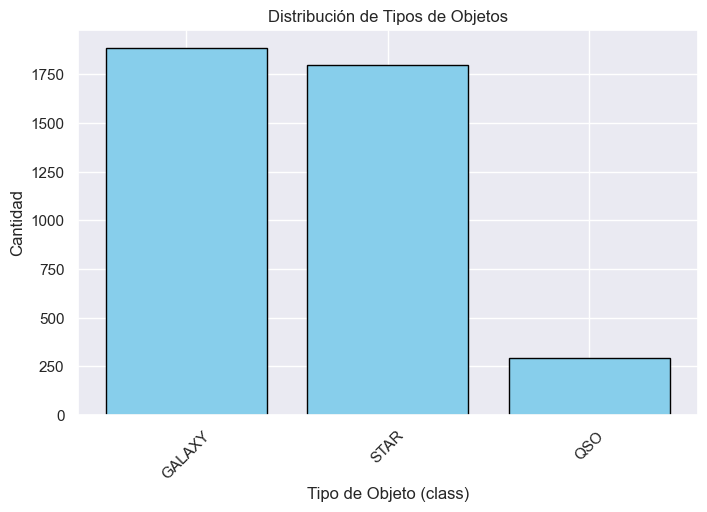

In [356]:
# Contar las ocurrencias de cada clase
class_counts = data['class'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

# Etiquetas y título
plt.xlabel("Tipo de Objeto (class)")
plt.ylabel("Cantidad")
plt.title("Distribución de Tipos de Objetos")
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad

# Mostrar el gráfico
plt.show()

Eliminación de la columna class

In [357]:
data=data.drop(["class"],axis=1)
data.head()

,ra,dec,u,g,r,z,i,redshift,mjd,GALAXY,QSO,STAR
0,185.574486,40.187398,19.11034,17.62099,17.03464,16.71711,16.82993,8.780529e-05,54140,0,0,1
1,203.801841,-48.925211,18.90957,17.62940,17.01465,16.35239,16.62059,8.619995e-02,51955,1,0,0
2,160.034264,-24.157376,19.26340,17.67693,16.82551,16.13864,16.42307,1.330486e-01,51913,1,0,0
3,200.807373,-39.077125,18.82022,17.77765,17.38575,16.93540,17.11128,8.636355e-02,51959,1,0,0
4,189.792404,-57.380593,18.91391,19.05355,19.46278,20.09613,19.75660,-4.090000e-08,54562,0,0,1


Actualización features

In [358]:
features=["ra","dec","u","g","r","z","i","redshift","mjd","GALAXY","QSO","STAR"]

## Regresión lineal

<Axes: >

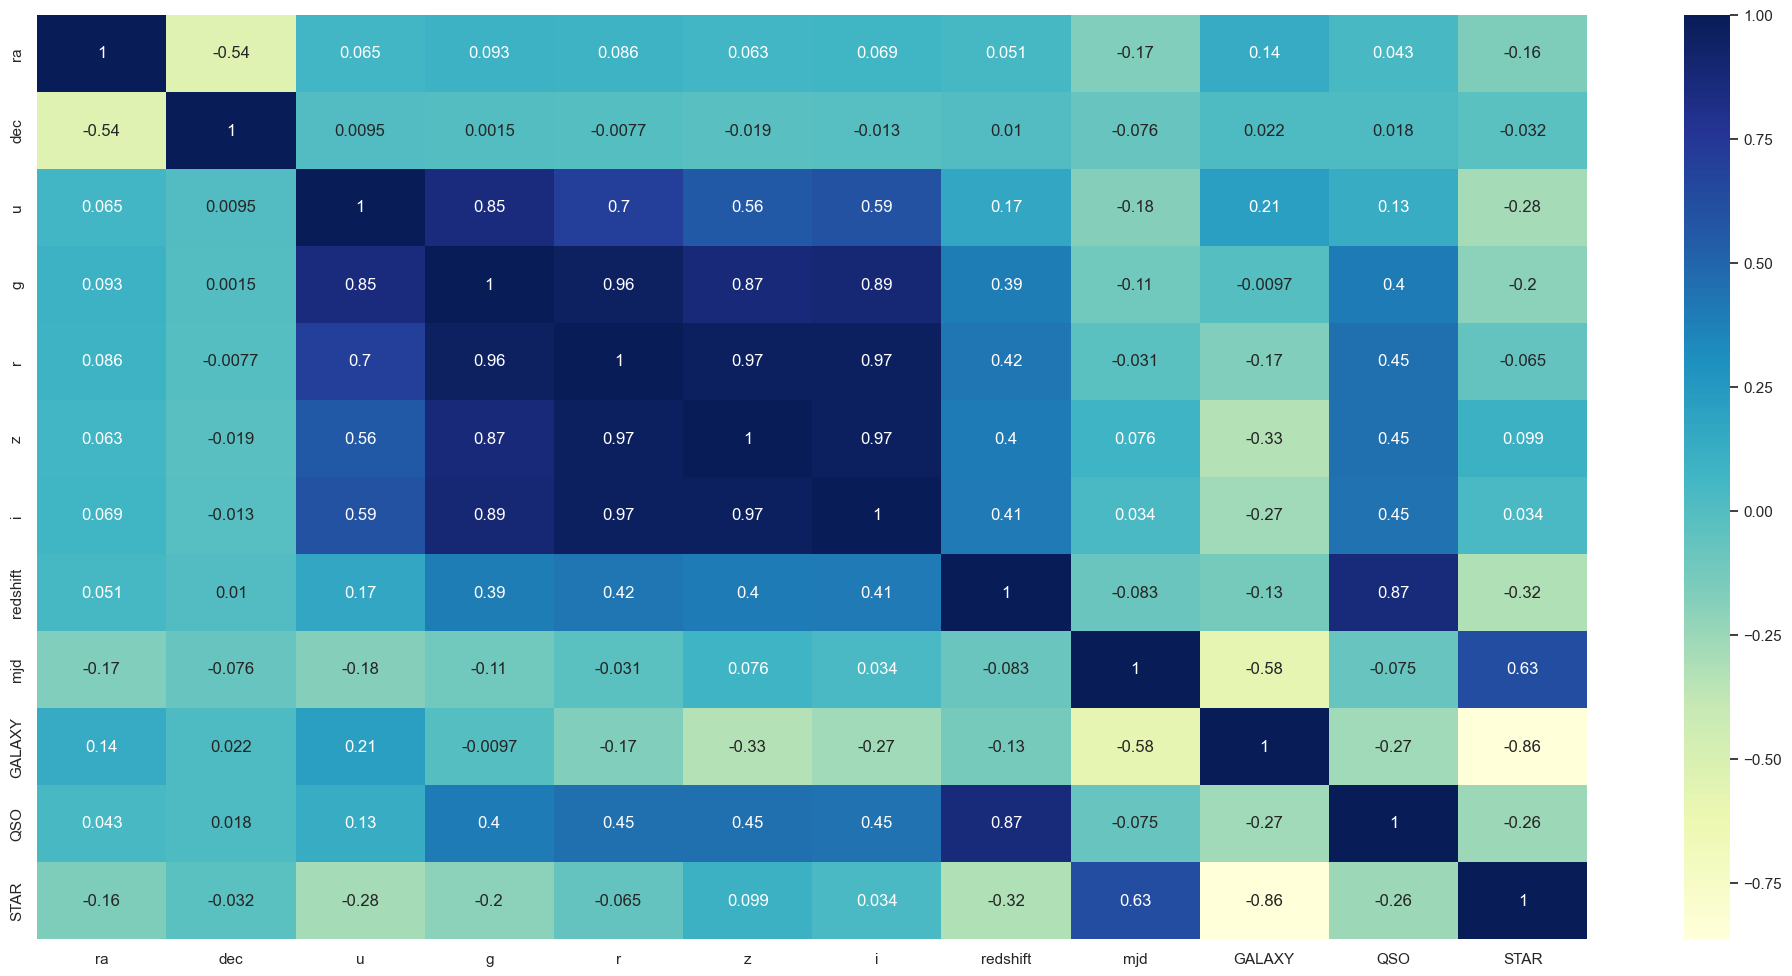

In [359]:
sb.set(rc={"figure.figsize":(25,12)})
sb.heatmap( data.corr(),annot=True, cmap="YlGnBu" )

In [360]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=["redshift", "mjd"])  # Eliminamos redshift y mjd
y = data["redshift"]  # Variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [361]:
X_train.shape, y_train.shape

((2781, 10), (2781,))

In [362]:
X_test.shape, y_test.shape

((1193, 10), (1193,))

In [363]:
from sklearn.linear_model import LinearRegression

# Crear y entrenar el modelo
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

Interpretación de los coeficientes y del intercepto

In [364]:
features = X.columns
pd.DataFrame({"columns": features, "coef": regression.coef_})

,columns,coef
0,ra,-0.000154
1,dec,-0.000067
2,u,-0.010481
3,g,-0.029490
4,r,0.099402
5,z,-0.044306
6,i,-0.001864
7,GALAXY,-0.372040
8,QSO,0.824304
9,STAR,-0.452264


Intercepto de la regresión

In [365]:
regression.intercept_

0.2773696264634458

In [366]:
#PRUEBA
# y_test=np.expm1(y_test)

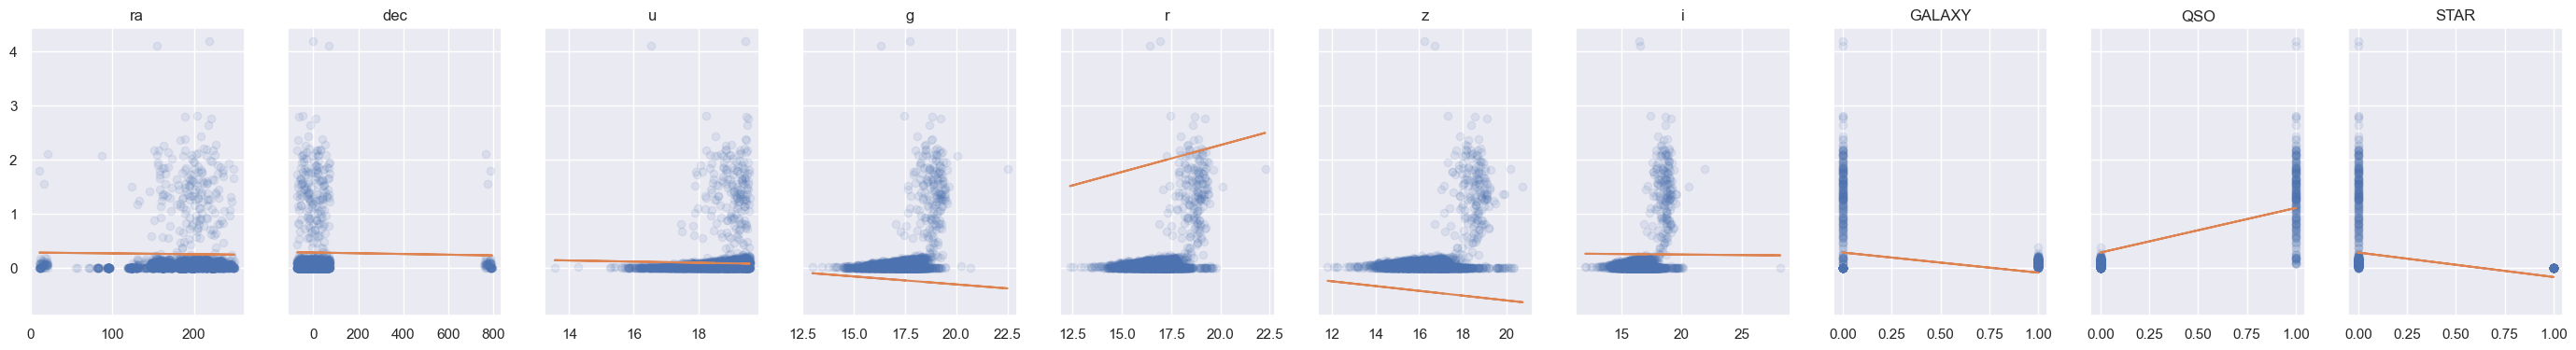

In [367]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(35, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

Validación del modelo

**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

In [368]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

Train: 0.05976846030946444
Test: 0.06084043768668658


**Root Mean Squeared Error (RMSE)**

$$ RMSE =  \sqrt{{1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } }$$

In [369]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 0.1885549874528756
Test: 0.18082800448909048


In [370]:
r2_train = r2_score(y_train, regression.predict(X_train))
r2_test = r2_score(y_test, regression.predict(X_test))

print("R^2 Train:", r2_train)
print("R^2 Test:", r2_test)


R^2 Train: 0.7627480051336354
R^2 Test: 0.7556255720189882


Análisis del error

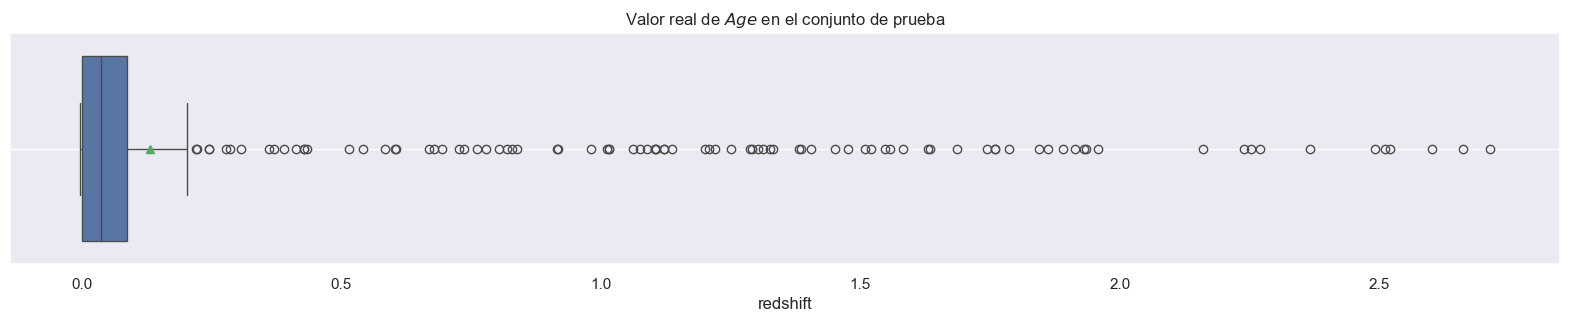

In [371]:
plt.figure(figsize=(20, 3))
sb.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Age}$ en el conjunto de prueba")
plt.grid()
plt.show()

## Entrenamiento de un segundo modelo aplicando normalización

In [372]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [373]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [374]:
pd.DataFrame({"columns": features, "coef": pipeline["model"].coef_})

,columns,coef
0,ra,-0.006531
1,dec,-0.008070
2,u,-0.008879
3,g,-0.028296
4,r,0.105620
5,z,-0.052926
6,i,-0.002137
7,GALAXY,-0.055317
8,QSO,0.285521
9,STAR,-0.095321


In [375]:
pipeline["model"].intercept_

0.13547349635569383

In [376]:
y_train.mean(), y_test.mean()

(0.13547349635569367, 0.1322783529843336)

In [377]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))


MAE:
Train: 0.059768460309466025
Test: 0.060840437686687655


In [378]:
print("RMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

RMSE:
Train: 0.1885549874528756
Test: 0.18082800448909053


## Validación de supuestos de la regresión

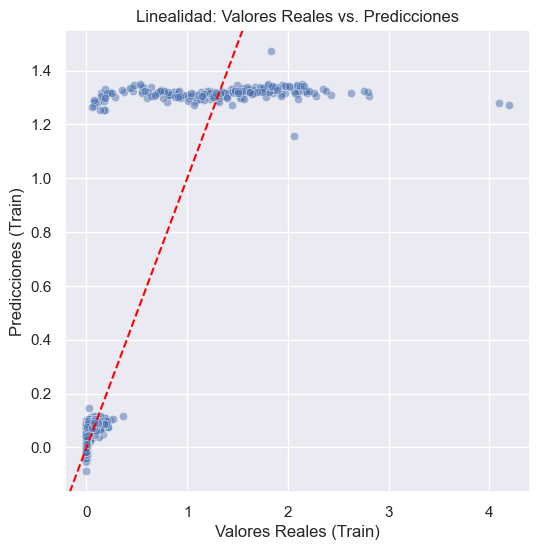

In [379]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_train = pipeline.predict(X_train)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_train, y=y_pred_train, alpha=0.5)
plt.xlabel("Valores Reales (Train)")
plt.ylabel("Predicciones (Train)")
plt.title("Linealidad: Valores Reales vs. Predicciones")
plt.axline((0, 0), slope=1, color="red", linestyle="--")
plt.show()


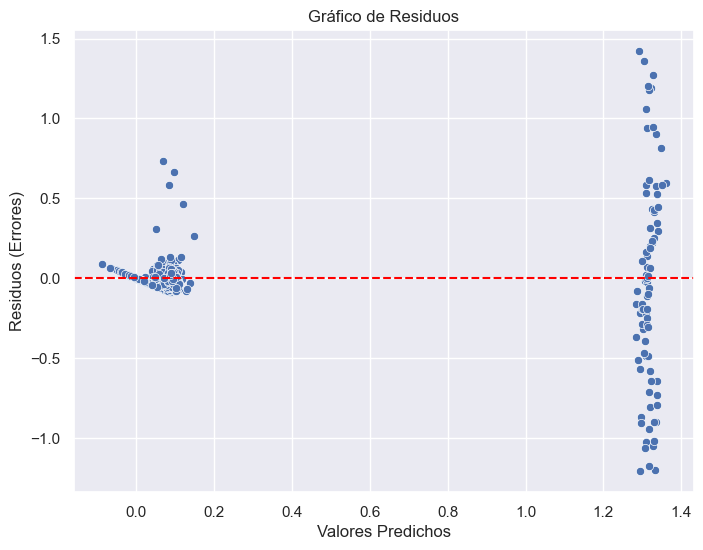

In [380]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculamos los residuos
residuos = y_test - pipeline.predict(X_test)

# Graficamos los residuos vs. predicciones
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pipeline.predict(X_test), y=residuos)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos (Errores)")
plt.title("Gráfico de Residuos")
plt.show()



In [381]:
import numpy as np
print("Desviación estándar de los residuos:", np.std(residuos))



Desviación estándar de los residuos: 0.180821232772595


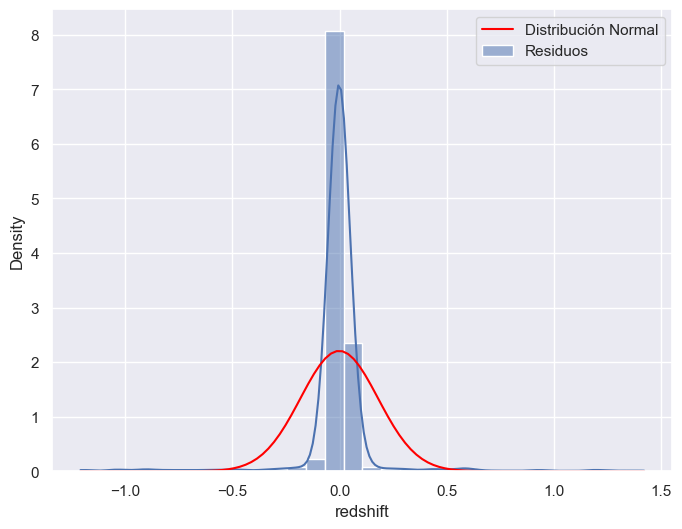

In [382]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Ajustamos una distribución normal a los residuos
mu, std = stats.norm.fit(residuos)

# Graficamos la distribución teórica
plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=30, kde=True, stat="density", label="Residuos")
x = np.linspace(min(residuos), max(residuos), 100)
plt.plot(x, stats.norm.pdf(x, mu, std), color="red", label="Distribución Normal")
plt.legend()
plt.show()


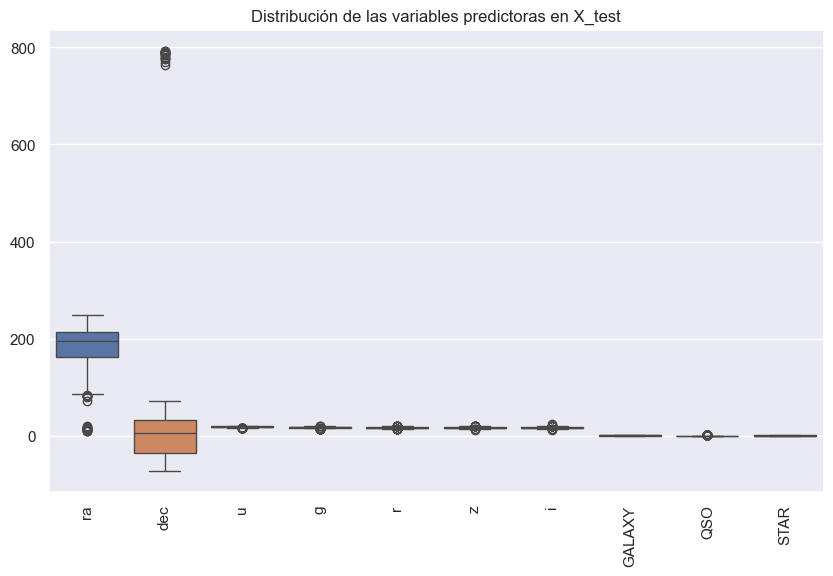

In [383]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_test)
plt.xticks(rotation=90)
plt.title("Distribución de las variables predictoras en X_test")
plt.show()


In [384]:
import scipy.stats as stats

corr, p_value = stats.pearsonr(data["dec"], data["redshift"])
print(f"Correlación: {corr}, p-valor: {p_value}")


Correlación: 0.010068028404059097, p-valor: 0.5257535210693709
